# UC Merced Land Use Dataset Classification
http://weegee.vision.ucmerced.edu/datasets/landuse.html

## Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !unzip /content/drive/MyDrive/ece285_project/DataSets/UCMerced_LandUse.zip -d /content/drive/MyDrive/ece285_project/DataSets/

In [4]:
import os
import json
import time
import copy
import pickle

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import ToTensor, Resize
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

plt.ion()

import sys
sys.path.append('/content/drive/MyDrive/ece285_project/other_projects/SimCLR_v1/')
from models.resnet_simclr import ResNetSimCLR

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading Data

In [6]:
root_path = '/content/drive/MyDrive/ece285_project'

In [7]:
label_map = json.load(open(os.path.join(root_path, 'DataSets/UCMerced_LandUse/label_map.json'), 'r'))
label_map_rev = {v:k for k,v in label_map.items()}
label_map

{'agricultural': 0,
 'airplane': 1,
 'baseballdiamond': 2,
 'beach': 3,
 'buildings': 4,
 'chaparral': 5,
 'denseresidential': 6,
 'forest': 7,
 'freeway': 8,
 'golfcourse': 9,
 'harbor': 20,
 'intersection': 10,
 'mediumresidential': 11,
 'mobilehomepark': 12,
 'overpass': 13,
 'parkinglot': 14,
 'river': 15,
 'runway': 16,
 'sparseresidential': 17,
 'storagetanks': 18,
 'tenniscourt': 19}

In [8]:
train_image_paths = []
valid_image_paths = []
test_image_paths = []
imgs_path = 'DataSets/UCMerced_LandUse/Images/'

label_folders = os.listdir(os.path.join(root_path, imgs_path))

for folder in label_folders:
  imgs = os.listdir(os.path.join(root_path, imgs_path, folder))
  for img in imgs:
    val = int(img.split('.')[0][-2:])
    if val <= 59:
      train_image_paths.append(os.path.join(imgs_path, folder, img))
    elif val<=79:
      valid_image_paths.append(os.path.join(imgs_path, folder, img))
    else:
      test_image_paths.append(os.path.join(imgs_path, folder, img))

train_image_paths = pd.DataFrame(train_image_paths, columns=['train_img_path'])
valid_image_paths = pd.DataFrame(valid_image_paths, columns=['valid_img_path'])
test_image_paths = pd.DataFrame(test_image_paths, columns=['test_img_path'])

In [9]:
print(len(train_image_paths))
print(len(valid_image_paths))
print(len(test_image_paths))

1260
420
420


## PyTorch DataLoader

In [10]:
train_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

test_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

# data_transforms = transforms.Compose([
#             transforms.RandomSizedCrop(224),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#   ])

In [11]:
class ImageDataset(Dataset):
  def __init__(self, image_paths, label_map, transform=None, target_transform=None):
    self.image_paths = image_paths
    self.label_map = label_map
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths.iloc[idx, 0]
    image = Image.open(os.path.join(root_path, img_path))
    label = torch.tensor(self.label_map[img_path.split('/')[-2]])

    if self.transform:
            image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [12]:
datasets = {
    'train': ImageDataset(train_image_paths, label_map, transform=train_transforms),
    'valid': ImageDataset(valid_image_paths, label_map, transform=test_transforms),
    'test': ImageDataset(test_image_paths, label_map, transform=test_transforms)
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid', 'test']}

# train_dataset = ImageDataset(train_image_paths, label_map, transform=data_transforms)
# valid_dataset = ImageDataset(valid_image_paths, label_map, transform=data_transforms)
# test_dataset = ImageDataset(test_image_paths, label_map, transform=data_transforms)

In [13]:
from torchvision.utils import make_grid

buildings


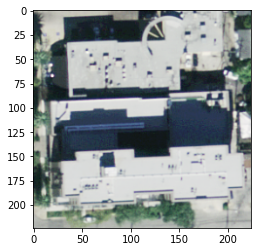

In [24]:
idx = np.random.choice(len(datasets['train']))

plt.imshow(datasets['train'][idx][0].permute(1,2,0))
print(label_map_rev[datasets['train'][idx][1].item()])

In [ ]:
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Training and Evaluate Pipeline

In [25]:
from tqdm import tqdm

In [26]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    metrics_dict = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # print(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='train':
              metrics_dict['train_loss'].append(epoch_loss)
              metrics_dict['train_acc'].append(epoch_acc.item())
            else:
              metrics_dict['valid_loss'].append(epoch_loss)
              metrics_dict['valid_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics_dict

In [27]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {label_map_rev[preds[j].item()]}')
                plt.imshow(inputs.cpu().data[j].T)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [28]:
def evaluate_model(model, dataloader):

    running_corrects = 0

    model.eval()
    with torch.no_grad():

      # Iterate over data.
      for inputs, labels in dataloader:
          # print(inputs)
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          # statistics
          running_corrects += torch.sum(preds == labels.data)
          # running_totals += len(labels)
    
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_acc.item()

## Model

In [29]:
# import torch
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

In [30]:
# model = models.resnet50(pretrained=False)

# # Changing the final layer
# model.fc = nn.Linear(model.fc.in_features, 21)

# model = model.to(device)

## Train and Evaluate

In [31]:
# BATCH_SIZE = 64
# EPOCHS = 50
# LR_RATE = 0.01
# MOMENTUM = 0.9

In [32]:
# dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
#                 for x in ['train', 'valid', 'test']}

In [33]:
# criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=LR_RATE, momentum=MOMENTUM)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

In [34]:
# model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

In [35]:
# evaluate_model(model, dataloaders['test'])

## Linear and Finetuned Evaluation

## Linear Evaluation - Supervised

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_le_sv = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    model.load_state_dict(torch.load(PATH)['net'])
    model = model.module
    model.fc = nn.Linear(model.fc.in_features, 21)
    for name, param in model.named_parameters():
      if 'fc' not in name:
        param.requires_grad = False
    model_le_sv = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_le_sv_best, metrics_dict = train_model(model_le_sv, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_le_sv_best, dataloaders['valid'])
    test_acc = evaluate_model(model_le_sv_best, dataloaders['test'])

    result_le_sv.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 2.9685 Acc: 0.1254


  1%|          | 1/100 [00:12<20:35, 12.48s/it]

valid Loss: 2.9661 Acc: 0.1119

Epoch 1/99
train Loss: 2.6097 Acc: 0.3563


  2%|▏         | 2/100 [00:21<16:36, 10.17s/it]

valid Loss: 2.6653 Acc: 0.2667

Epoch 2/99
train Loss: 2.3320 Acc: 0.4325


  3%|▎         | 3/100 [00:29<15:11,  9.40s/it]

valid Loss: 2.4822 Acc: 0.2619

Epoch 3/99
train Loss: 2.1445 Acc: 0.4405


  4%|▍         | 4/100 [00:38<14:27,  9.04s/it]

valid Loss: 2.4001 Acc: 0.2857

Epoch 4/99
train Loss: 2.0165 Acc: 0.4952


  5%|▌         | 5/100 [00:46<14:00,  8.84s/it]

valid Loss: 2.3375 Acc: 0.3048

Epoch 5/99
train Loss: 1.9034 Acc: 0.5103


  6%|▌         | 6/100 [00:55<13:41,  8.74s/it]

valid Loss: 2.2856 Acc: 0.3286

Epoch 6/99
train Loss: 1.8288 Acc: 0.5421


  7%|▋         | 7/100 [01:03<13:23,  8.64s/it]

valid Loss: 2.2552 Acc: 0.2952

Epoch 7/99
train Loss: 1.7693 Acc: 0.5349


  8%|▊         | 8/100 [01:12<13:18,  8.68s/it]

valid Loss: 2.2260 Acc: 0.3333

Epoch 8/99
train Loss: 1.7239 Acc: 0.5675


  9%|▉         | 9/100 [01:21<13:20,  8.80s/it]

valid Loss: 2.1980 Acc: 0.3048

Epoch 9/99
train Loss: 1.6703 Acc: 0.5659


 10%|█         | 10/100 [01:29<13:04,  8.71s/it]

valid Loss: 2.1787 Acc: 0.2857

Epoch 10/99
train Loss: 1.6329 Acc: 0.5921


 11%|█         | 11/100 [01:38<12:50,  8.66s/it]

valid Loss: 2.1535 Acc: 0.3405

Epoch 11/99
train Loss: 1.5919 Acc: 0.5817


 12%|█▏        | 12/100 [01:46<12:37,  8.61s/it]

valid Loss: 2.1521 Acc: 0.3310

Epoch 12/99
train Loss: 1.5523 Acc: 0.5905


 13%|█▎        | 13/100 [01:55<12:27,  8.59s/it]

valid Loss: 2.1303 Acc: 0.3357

Epoch 13/99
train Loss: 1.5415 Acc: 0.5881


 14%|█▍        | 14/100 [02:03<12:16,  8.57s/it]

valid Loss: 2.1339 Acc: 0.3190

Epoch 14/99
train Loss: 1.5038 Acc: 0.6135


 15%|█▌        | 15/100 [02:12<12:07,  8.55s/it]

valid Loss: 2.1013 Acc: 0.3571

Epoch 15/99
train Loss: 1.4852 Acc: 0.6000


 16%|█▌        | 16/100 [02:21<12:12,  8.72s/it]

valid Loss: 2.0964 Acc: 0.3429

Epoch 16/99
train Loss: 1.4575 Acc: 0.6143


 17%|█▋        | 17/100 [02:30<11:59,  8.67s/it]

valid Loss: 2.0847 Acc: 0.3357

Epoch 17/99
train Loss: 1.4454 Acc: 0.6270


 18%|█▊        | 18/100 [02:38<11:50,  8.66s/it]

valid Loss: 2.0879 Acc: 0.3476

Epoch 18/99
train Loss: 1.4189 Acc: 0.6317


 19%|█▉        | 19/100 [02:47<11:40,  8.65s/it]

valid Loss: 2.0572 Acc: 0.3595

Epoch 19/99
train Loss: 1.4054 Acc: 0.6325


 20%|██        | 20/100 [02:56<11:34,  8.69s/it]

valid Loss: 2.0435 Acc: 0.3595

Epoch 20/99
train Loss: 1.3873 Acc: 0.6310


 21%|██        | 21/100 [03:04<11:27,  8.70s/it]

valid Loss: 2.0513 Acc: 0.3571

Epoch 21/99
train Loss: 1.3825 Acc: 0.6341


 22%|██▏       | 22/100 [03:13<11:26,  8.80s/it]

valid Loss: 2.0416 Acc: 0.3619

Epoch 22/99
train Loss: 1.3419 Acc: 0.6429


 23%|██▎       | 23/100 [03:22<11:17,  8.80s/it]

valid Loss: 2.0350 Acc: 0.3714

Epoch 23/99
train Loss: 1.3395 Acc: 0.6421


 24%|██▍       | 24/100 [03:31<11:07,  8.78s/it]

valid Loss: 2.0180 Acc: 0.3500

Epoch 24/99
train Loss: 1.3113 Acc: 0.6611


 25%|██▌       | 25/100 [03:40<10:55,  8.74s/it]

valid Loss: 2.0229 Acc: 0.3881

Epoch 25/99
train Loss: 1.3058 Acc: 0.6516


 26%|██▌       | 26/100 [03:48<10:44,  8.71s/it]

valid Loss: 2.0179 Acc: 0.3738

Epoch 26/99
train Loss: 1.2990 Acc: 0.6548


 27%|██▋       | 27/100 [03:57<10:31,  8.65s/it]

valid Loss: 2.0174 Acc: 0.3714

Epoch 27/99
train Loss: 1.2725 Acc: 0.6667


 28%|██▊       | 28/100 [04:05<10:20,  8.62s/it]

valid Loss: 2.0013 Acc: 0.3690

Epoch 28/99
train Loss: 1.2525 Acc: 0.6722


 29%|██▉       | 29/100 [04:14<10:08,  8.57s/it]

valid Loss: 1.9993 Acc: 0.3690

Epoch 29/99
train Loss: 1.2444 Acc: 0.6722


 30%|███       | 30/100 [04:22<09:57,  8.54s/it]

valid Loss: 1.9864 Acc: 0.3667

Epoch 30/99
train Loss: 1.2337 Acc: 0.6794


 31%|███       | 31/100 [04:31<09:48,  8.53s/it]

valid Loss: 1.9868 Acc: 0.3786

Epoch 31/99
train Loss: 1.2221 Acc: 0.6810


 32%|███▏      | 32/100 [04:39<09:39,  8.53s/it]

valid Loss: 1.9867 Acc: 0.3762

Epoch 32/99
train Loss: 1.2288 Acc: 0.6738


 33%|███▎      | 33/100 [04:48<09:30,  8.51s/it]

valid Loss: 1.9637 Acc: 0.3857

Epoch 33/99
train Loss: 1.2066 Acc: 0.6810


 34%|███▍      | 34/100 [04:56<09:23,  8.53s/it]

valid Loss: 1.9833 Acc: 0.3643

Epoch 34/99
train Loss: 1.2039 Acc: 0.6833


 35%|███▌      | 35/100 [05:05<09:15,  8.55s/it]

valid Loss: 1.9830 Acc: 0.3762

Epoch 35/99
train Loss: 1.2016 Acc: 0.6746


 36%|███▌      | 36/100 [05:13<09:06,  8.53s/it]

valid Loss: 1.9662 Acc: 0.3690

Epoch 36/99
train Loss: 1.1954 Acc: 0.6802


 37%|███▋      | 37/100 [05:22<08:56,  8.51s/it]

valid Loss: 1.9586 Acc: 0.3833

Epoch 37/99
train Loss: 1.1794 Acc: 0.6762


 38%|███▊      | 38/100 [05:31<08:52,  8.59s/it]

valid Loss: 1.9591 Acc: 0.3714

Epoch 38/99
train Loss: 1.1602 Acc: 0.6897


 39%|███▉      | 39/100 [05:39<08:42,  8.57s/it]

valid Loss: 1.9662 Acc: 0.3810

Epoch 39/99
train Loss: 1.1702 Acc: 0.6754


 40%|████      | 40/100 [05:48<08:33,  8.55s/it]

valid Loss: 1.9548 Acc: 0.3905

Epoch 40/99
train Loss: 1.1503 Acc: 0.6960


 41%|████      | 41/100 [05:56<08:24,  8.55s/it]

valid Loss: 1.9526 Acc: 0.3833

Epoch 41/99
train Loss: 1.1440 Acc: 0.6881


 42%|████▏     | 42/100 [06:05<08:23,  8.68s/it]

valid Loss: 1.9468 Acc: 0.3810

Epoch 42/99
train Loss: 1.1430 Acc: 0.6825


 43%|████▎     | 43/100 [06:14<08:11,  8.62s/it]

valid Loss: 1.9367 Acc: 0.3786

Epoch 43/99
train Loss: 1.1321 Acc: 0.7063


 44%|████▍     | 44/100 [06:22<08:00,  8.58s/it]

valid Loss: 1.9445 Acc: 0.3833

Epoch 44/99
train Loss: 1.1236 Acc: 0.7008


 45%|████▌     | 45/100 [06:31<07:49,  8.54s/it]

valid Loss: 1.9298 Acc: 0.3714

Epoch 45/99
train Loss: 1.1259 Acc: 0.7024


 46%|████▌     | 46/100 [06:39<07:40,  8.53s/it]

valid Loss: 1.9451 Acc: 0.3714

Epoch 46/99
train Loss: 1.1301 Acc: 0.6937


 47%|████▋     | 47/100 [06:48<07:31,  8.52s/it]

valid Loss: 1.9432 Acc: 0.3762

Epoch 47/99
train Loss: 1.1009 Acc: 0.7063


 48%|████▊     | 48/100 [06:56<07:22,  8.51s/it]

valid Loss: 1.9251 Acc: 0.3786

Epoch 48/99
train Loss: 1.1188 Acc: 0.7048


 49%|████▉     | 49/100 [07:05<07:14,  8.51s/it]

valid Loss: 1.9301 Acc: 0.4024

Epoch 49/99
train Loss: 1.0987 Acc: 0.7032


 50%|█████     | 50/100 [07:13<07:06,  8.52s/it]

valid Loss: 1.9264 Acc: 0.3810

Epoch 50/99
train Loss: 1.0931 Acc: 0.7127


 51%|█████     | 51/100 [07:22<06:56,  8.50s/it]

valid Loss: 1.9222 Acc: 0.3786

Epoch 51/99
train Loss: 1.0904 Acc: 0.7198


 52%|█████▏    | 52/100 [07:30<06:48,  8.50s/it]

valid Loss: 1.9199 Acc: 0.3738

Epoch 52/99
train Loss: 1.0741 Acc: 0.7270


 53%|█████▎    | 53/100 [07:39<06:39,  8.50s/it]

valid Loss: 1.9299 Acc: 0.3786

Epoch 53/99
train Loss: 1.0764 Acc: 0.7214


 54%|█████▍    | 54/100 [07:47<06:30,  8.49s/it]

valid Loss: 1.9188 Acc: 0.3833

Epoch 54/99
train Loss: 1.0738 Acc: 0.7111


 55%|█████▌    | 55/100 [07:56<06:22,  8.49s/it]

valid Loss: 1.9292 Acc: 0.3786

Epoch 55/99
train Loss: 1.0560 Acc: 0.7135


 56%|█████▌    | 56/100 [08:04<06:13,  8.48s/it]

valid Loss: 1.9186 Acc: 0.3881

Epoch 56/99
train Loss: 1.0549 Acc: 0.7262


 57%|█████▋    | 57/100 [08:12<06:04,  8.48s/it]

valid Loss: 1.9260 Acc: 0.3833

Epoch 57/99
train Loss: 1.0684 Acc: 0.7175


 58%|█████▊    | 58/100 [08:21<05:56,  8.48s/it]

valid Loss: 1.9126 Acc: 0.3905

Epoch 58/99
train Loss: 1.0603 Acc: 0.7135


 59%|█████▉    | 59/100 [08:30<05:50,  8.54s/it]

valid Loss: 1.9060 Acc: 0.3929

Epoch 59/99
train Loss: 1.0502 Acc: 0.7238


 60%|██████    | 60/100 [08:38<05:43,  8.58s/it]

valid Loss: 1.9281 Acc: 0.3881

Epoch 60/99
train Loss: 1.0433 Acc: 0.7230


 61%|██████    | 61/100 [08:47<05:33,  8.55s/it]

valid Loss: 1.9223 Acc: 0.3762

Epoch 61/99
train Loss: 1.0512 Acc: 0.7135


 62%|██████▏   | 62/100 [08:55<05:25,  8.55s/it]

valid Loss: 1.9107 Acc: 0.3881

Epoch 62/99
train Loss: 1.0274 Acc: 0.7246


 63%|██████▎   | 63/100 [09:04<05:18,  8.62s/it]

valid Loss: 1.9193 Acc: 0.3976

Epoch 63/99
train Loss: 1.0360 Acc: 0.7278


 64%|██████▍   | 64/100 [09:13<05:10,  8.64s/it]

valid Loss: 1.9282 Acc: 0.3952

Epoch 64/99
train Loss: 1.0379 Acc: 0.7111


 65%|██████▌   | 65/100 [09:21<05:00,  8.58s/it]

valid Loss: 1.9076 Acc: 0.3857

Epoch 65/99
train Loss: 1.0262 Acc: 0.7159


 66%|██████▌   | 66/100 [09:30<04:51,  8.56s/it]

valid Loss: 1.9186 Acc: 0.3952

Epoch 66/99
train Loss: 1.0166 Acc: 0.7294


 67%|██████▋   | 67/100 [09:38<04:42,  8.56s/it]

valid Loss: 1.8982 Acc: 0.4167

Epoch 67/99
train Loss: 1.0249 Acc: 0.7349


 68%|██████▊   | 68/100 [09:47<04:33,  8.54s/it]

valid Loss: 1.9047 Acc: 0.3810

Epoch 68/99
train Loss: 1.0100 Acc: 0.7381


 69%|██████▉   | 69/100 [09:55<04:24,  8.53s/it]

valid Loss: 1.9150 Acc: 0.3905

Epoch 69/99
train Loss: 1.0225 Acc: 0.7278


 70%|███████   | 70/100 [10:04<04:15,  8.53s/it]

valid Loss: 1.9061 Acc: 0.3929

Epoch 70/99
train Loss: 1.0191 Acc: 0.7405


 71%|███████   | 71/100 [10:12<04:07,  8.52s/it]

valid Loss: 1.9010 Acc: 0.3905

Epoch 71/99
train Loss: 1.0106 Acc: 0.7246


 72%|███████▏  | 72/100 [10:21<03:58,  8.51s/it]

valid Loss: 1.9035 Acc: 0.3905

Epoch 72/99
train Loss: 0.9901 Acc: 0.7254


 73%|███████▎  | 73/100 [10:29<03:49,  8.51s/it]

valid Loss: 1.9051 Acc: 0.3952

Epoch 73/99
train Loss: 0.9954 Acc: 0.7524


 74%|███████▍  | 74/100 [10:38<03:41,  8.51s/it]

valid Loss: 1.8986 Acc: 0.4024

Epoch 74/99
train Loss: 0.9787 Acc: 0.7492


 75%|███████▌  | 75/100 [10:46<03:32,  8.51s/it]

valid Loss: 1.8943 Acc: 0.4071

Epoch 75/99
train Loss: 0.9852 Acc: 0.7413


 76%|███████▌  | 76/100 [10:55<03:24,  8.50s/it]

valid Loss: 1.9160 Acc: 0.3952

Epoch 76/99
train Loss: 0.9846 Acc: 0.7452


 77%|███████▋  | 77/100 [11:03<03:15,  8.52s/it]

valid Loss: 1.8933 Acc: 0.3976

Epoch 77/99
train Loss: 0.9910 Acc: 0.7460


 78%|███████▊  | 78/100 [11:12<03:07,  8.52s/it]

valid Loss: 1.8999 Acc: 0.4048

Epoch 78/99
train Loss: 0.9840 Acc: 0.7405


 79%|███████▉  | 79/100 [11:20<02:59,  8.53s/it]

valid Loss: 1.9033 Acc: 0.3976

Epoch 79/99
train Loss: 0.9869 Acc: 0.7373


 80%|████████  | 80/100 [11:29<02:50,  8.51s/it]

valid Loss: 1.9032 Acc: 0.3976

Epoch 80/99
train Loss: 0.9718 Acc: 0.7500


 81%|████████  | 81/100 [11:37<02:41,  8.51s/it]

valid Loss: 1.8917 Acc: 0.4119

Epoch 81/99
train Loss: 0.9704 Acc: 0.7476


 82%|████████▏ | 82/100 [11:46<02:33,  8.50s/it]

valid Loss: 1.8998 Acc: 0.4000

Epoch 82/99
train Loss: 0.9831 Acc: 0.7468


 83%|████████▎ | 83/100 [11:55<02:25,  8.53s/it]

valid Loss: 1.8913 Acc: 0.3976

Epoch 83/99
train Loss: 0.9558 Acc: 0.7437


 84%|████████▍ | 84/100 [12:03<02:16,  8.53s/it]

valid Loss: 1.8914 Acc: 0.4071

Epoch 84/99
train Loss: 0.9510 Acc: 0.7484


 85%|████████▌ | 85/100 [12:12<02:10,  8.68s/it]

valid Loss: 1.8871 Acc: 0.4119

Epoch 85/99
train Loss: 0.9683 Acc: 0.7492


 86%|████████▌ | 86/100 [12:21<02:01,  8.65s/it]

valid Loss: 1.8927 Acc: 0.4048

Epoch 86/99
train Loss: 0.9562 Acc: 0.7389


 87%|████████▋ | 87/100 [12:29<01:52,  8.62s/it]

valid Loss: 1.8740 Acc: 0.4167

Epoch 87/99
train Loss: 0.9665 Acc: 0.7492


 88%|████████▊ | 88/100 [12:38<01:43,  8.60s/it]

valid Loss: 1.8814 Acc: 0.4095

Epoch 88/99
train Loss: 0.9568 Acc: 0.7627


 89%|████████▉ | 89/100 [12:46<01:34,  8.58s/it]

valid Loss: 1.9091 Acc: 0.3905

Epoch 89/99
train Loss: 0.9494 Acc: 0.7508


 90%|█████████ | 90/100 [12:55<01:25,  8.56s/it]

valid Loss: 1.8972 Acc: 0.4095

Epoch 90/99
train Loss: 0.9433 Acc: 0.7587


 91%|█████████ | 91/100 [13:03<01:17,  8.56s/it]

valid Loss: 1.8855 Acc: 0.4119

Epoch 91/99
train Loss: 0.9414 Acc: 0.7587


 92%|█████████▏| 92/100 [13:12<01:08,  8.56s/it]

valid Loss: 1.8871 Acc: 0.4143

Epoch 92/99
train Loss: 0.9569 Acc: 0.7524


 93%|█████████▎| 93/100 [13:20<00:59,  8.55s/it]

valid Loss: 1.8906 Acc: 0.4143

Epoch 93/99
train Loss: 0.9510 Acc: 0.7563


 94%|█████████▍| 94/100 [13:29<00:51,  8.55s/it]

valid Loss: 1.8938 Acc: 0.4190

Epoch 94/99
train Loss: 0.9453 Acc: 0.7571


 95%|█████████▌| 95/100 [13:38<00:42,  8.56s/it]

valid Loss: 1.8924 Acc: 0.4119

Epoch 95/99
train Loss: 0.9501 Acc: 0.7556


 96%|█████████▌| 96/100 [13:46<00:34,  8.63s/it]

valid Loss: 1.8845 Acc: 0.4190

Epoch 96/99
train Loss: 0.9335 Acc: 0.7556


 97%|█████████▋| 97/100 [13:55<00:25,  8.63s/it]

valid Loss: 1.8842 Acc: 0.4048

Epoch 97/99
train Loss: 0.9286 Acc: 0.7659


 98%|█████████▊| 98/100 [14:04<00:17,  8.85s/it]

valid Loss: 1.8823 Acc: 0.4262

Epoch 98/99
train Loss: 0.9599 Acc: 0.7468


 99%|█████████▉| 99/100 [14:13<00:08,  8.79s/it]

valid Loss: 1.8831 Acc: 0.4071

Epoch 99/99
train Loss: 0.9276 Acc: 0.7627


100%|██████████| 100/100 [14:22<00:00,  8.62s/it]

valid Loss: 1.8918 Acc: 0.4095

Training complete in 14m 22s
Best val Acc: 0.426190


In [ ]:
result_df = pd.DataFrame(result_le_sv, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.42619,0.352381,"{'train_loss': [2.968537736317468, 2.609731720..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_sv.pkl')
# result_df.to_csv('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_sv.csv', index=False)

## Linear Evaluation - SSL

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_le_ssl = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
    model = ResNetSimCLR('resnet50', 128)
    model.load_state_dict(torch.load(PATH)['state_dict'])
    model = model.backbone
    model.fc = nn.Linear(model.fc[2].in_features, 21)
    for name, param in model.named_parameters():
      if 'fc' not in name:
        param.requires_grad = False
    model_le_ssl = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_le_ssl_best, metrics_dict = train_model(model_le_ssl, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_le_ssl_best, dataloaders['valid'])
    test_acc = evaluate_model(model_le_ssl_best, dataloaders['test'])

    result_le_ssl.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 2.7638 Acc: 0.2040


  1%|          | 1/100 [00:10<17:13, 10.44s/it]

valid Loss: 2.4508 Acc: 0.2833

Epoch 1/99
train Loss: 2.0911 Acc: 0.4040


  2%|▏         | 2/100 [00:20<16:19, 10.00s/it]

valid Loss: 2.0553 Acc: 0.3667

Epoch 2/99
train Loss: 1.7338 Acc: 0.5413


  3%|▎         | 3/100 [00:28<15:19,  9.48s/it]

valid Loss: 1.9069 Acc: 0.3690

Epoch 3/99
train Loss: 1.5774 Acc: 0.5786


  4%|▍         | 4/100 [00:37<14:38,  9.15s/it]

valid Loss: 1.9060 Acc: 0.3810

Epoch 4/99
train Loss: 1.5146 Acc: 0.5659


  5%|▌         | 5/100 [00:46<14:07,  8.92s/it]

valid Loss: 1.7903 Acc: 0.4429

Epoch 5/99
train Loss: 1.4080 Acc: 0.5921


  6%|▌         | 6/100 [00:54<13:41,  8.74s/it]

valid Loss: 1.8047 Acc: 0.4143

Epoch 6/99
train Loss: 1.3300 Acc: 0.6405


  7%|▋         | 7/100 [01:03<13:39,  8.81s/it]

valid Loss: 1.7917 Acc: 0.4071

Epoch 7/99
train Loss: 1.2971 Acc: 0.6381


  8%|▊         | 8/100 [01:12<13:24,  8.74s/it]

valid Loss: 1.7551 Acc: 0.4452

Epoch 8/99
train Loss: 1.2452 Acc: 0.6452


  9%|▉         | 9/100 [01:20<13:06,  8.64s/it]

valid Loss: 1.7716 Acc: 0.4143

Epoch 9/99
train Loss: 1.1887 Acc: 0.6706


 10%|█         | 10/100 [01:28<12:50,  8.56s/it]

valid Loss: 1.7435 Acc: 0.4381

Epoch 10/99
train Loss: 1.1590 Acc: 0.6825


 11%|█         | 11/100 [01:37<12:38,  8.52s/it]

valid Loss: 1.7375 Acc: 0.4571

Epoch 11/99
train Loss: 1.1353 Acc: 0.6825


 12%|█▏        | 12/100 [01:45<12:25,  8.48s/it]

valid Loss: 1.7543 Acc: 0.4452

Epoch 12/99
train Loss: 1.0965 Acc: 0.6960


 13%|█▎        | 13/100 [01:54<12:24,  8.55s/it]

valid Loss: 1.6957 Acc: 0.4595

Epoch 13/99
train Loss: 1.0705 Acc: 0.7095


 14%|█▍        | 14/100 [02:03<12:24,  8.66s/it]

valid Loss: 1.7042 Acc: 0.4405

Epoch 14/99
train Loss: 1.0490 Acc: 0.7143


 15%|█▌        | 15/100 [02:11<12:09,  8.58s/it]

valid Loss: 1.7077 Acc: 0.4524

Epoch 15/99
train Loss: 1.0300 Acc: 0.7214


 16%|█▌        | 16/100 [02:20<11:57,  8.54s/it]

valid Loss: 1.7229 Acc: 0.4667

Epoch 16/99
train Loss: 1.0098 Acc: 0.7365


 17%|█▋        | 17/100 [02:28<11:45,  8.50s/it]

valid Loss: 1.6790 Acc: 0.4643

Epoch 17/99
train Loss: 1.0158 Acc: 0.7238


 18%|█▊        | 18/100 [02:37<11:35,  8.48s/it]

valid Loss: 1.6711 Acc: 0.4357

Epoch 18/99
train Loss: 1.0012 Acc: 0.7325


 19%|█▉        | 19/100 [02:45<11:23,  8.44s/it]

valid Loss: 1.7113 Acc: 0.4643

Epoch 19/99
train Loss: 0.9793 Acc: 0.7341


 20%|██        | 20/100 [02:53<11:14,  8.43s/it]

valid Loss: 1.6957 Acc: 0.4738

Epoch 20/99
train Loss: 0.9640 Acc: 0.7333


 21%|██        | 21/100 [03:02<11:06,  8.43s/it]

valid Loss: 1.6794 Acc: 0.4690

Epoch 21/99
train Loss: 0.9426 Acc: 0.7437


 22%|██▏       | 22/100 [03:10<10:56,  8.42s/it]

valid Loss: 1.7246 Acc: 0.4643

Epoch 22/99
train Loss: 0.9524 Acc: 0.7429


 23%|██▎       | 23/100 [03:19<10:52,  8.48s/it]

valid Loss: 1.6823 Acc: 0.4857

Epoch 23/99
train Loss: 0.9139 Acc: 0.7532


 24%|██▍       | 24/100 [03:28<10:54,  8.61s/it]

valid Loss: 1.6541 Acc: 0.5048

Epoch 24/99
train Loss: 0.9216 Acc: 0.7444


 25%|██▌       | 25/100 [03:36<10:45,  8.60s/it]

valid Loss: 1.6614 Acc: 0.4714

Epoch 25/99
train Loss: 0.9205 Acc: 0.7444


 26%|██▌       | 26/100 [03:45<10:32,  8.55s/it]

valid Loss: 1.6395 Acc: 0.4833

Epoch 26/99
train Loss: 0.9081 Acc: 0.7492


 27%|██▋       | 27/100 [03:53<10:21,  8.51s/it]

valid Loss: 1.6795 Acc: 0.4833

Epoch 27/99
train Loss: 0.8831 Acc: 0.7667


 28%|██▊       | 28/100 [04:01<10:10,  8.47s/it]

valid Loss: 1.6497 Acc: 0.4857

Epoch 28/99
train Loss: 0.8696 Acc: 0.7635


 29%|██▉       | 29/100 [04:10<10:04,  8.52s/it]

valid Loss: 1.6726 Acc: 0.4738

Epoch 29/99
train Loss: 0.8740 Acc: 0.7611


 30%|███       | 30/100 [04:19<09:56,  8.53s/it]

valid Loss: 1.6322 Acc: 0.4929

Epoch 30/99
train Loss: 0.8581 Acc: 0.7770


 31%|███       | 31/100 [04:27<09:47,  8.51s/it]

valid Loss: 1.6691 Acc: 0.4929

Epoch 31/99
train Loss: 0.8692 Acc: 0.7675


 32%|███▏      | 32/100 [04:36<09:38,  8.51s/it]

valid Loss: 1.6459 Acc: 0.4881

Epoch 32/99
train Loss: 0.8426 Acc: 0.7841


 33%|███▎      | 33/100 [04:44<09:29,  8.49s/it]

valid Loss: 1.6415 Acc: 0.4952

Epoch 33/99
train Loss: 0.8432 Acc: 0.7754


 34%|███▍      | 34/100 [04:52<09:18,  8.47s/it]

valid Loss: 1.6505 Acc: 0.4833

Epoch 34/99
train Loss: 0.8304 Acc: 0.7833


 35%|███▌      | 35/100 [05:01<09:09,  8.45s/it]

valid Loss: 1.6643 Acc: 0.4738

Epoch 35/99
train Loss: 0.8378 Acc: 0.7794


 36%|███▌      | 36/100 [05:09<09:00,  8.44s/it]

valid Loss: 1.6455 Acc: 0.4952

Epoch 36/99
train Loss: 0.8301 Acc: 0.7881


 37%|███▋      | 37/100 [05:18<08:52,  8.46s/it]

valid Loss: 1.6488 Acc: 0.5095

Epoch 37/99
train Loss: 0.8238 Acc: 0.7857


 38%|███▊      | 38/100 [05:26<08:42,  8.43s/it]

valid Loss: 1.6347 Acc: 0.4905

Epoch 38/99
train Loss: 0.8052 Acc: 0.7817


 39%|███▉      | 39/100 [05:35<08:33,  8.43s/it]

valid Loss: 1.6528 Acc: 0.4810

Epoch 39/99
train Loss: 0.8012 Acc: 0.7976


 40%|████      | 40/100 [05:43<08:24,  8.42s/it]

valid Loss: 1.6373 Acc: 0.4929

Epoch 40/99
train Loss: 0.8116 Acc: 0.7849


 41%|████      | 41/100 [05:51<08:16,  8.42s/it]

valid Loss: 1.6502 Acc: 0.4857

Epoch 41/99
train Loss: 0.7896 Acc: 0.7849


 42%|████▏     | 42/100 [06:00<08:08,  8.42s/it]

valid Loss: 1.6365 Acc: 0.4905

Epoch 42/99
train Loss: 0.7765 Acc: 0.7921


 43%|████▎     | 43/100 [06:08<08:00,  8.43s/it]

valid Loss: 1.6823 Acc: 0.4905

Epoch 43/99
train Loss: 0.7887 Acc: 0.7905


 44%|████▍     | 44/100 [06:17<07:51,  8.43s/it]

valid Loss: 1.6628 Acc: 0.4929

Epoch 44/99
train Loss: 0.7686 Acc: 0.7865


 45%|████▌     | 45/100 [06:25<07:43,  8.42s/it]

valid Loss: 1.6482 Acc: 0.4952

Epoch 45/99
train Loss: 0.7955 Acc: 0.7849


 46%|████▌     | 46/100 [06:34<07:34,  8.42s/it]

valid Loss: 1.6643 Acc: 0.4857

Epoch 46/99
train Loss: 0.8031 Acc: 0.7841


 47%|████▋     | 47/100 [06:42<07:26,  8.42s/it]

valid Loss: 1.6517 Acc: 0.5024

Epoch 47/99
train Loss: 0.7693 Acc: 0.7937


 48%|████▊     | 48/100 [06:50<07:17,  8.41s/it]

valid Loss: 1.6338 Acc: 0.5071

Epoch 48/99
train Loss: 0.7663 Acc: 0.7897


 49%|████▉     | 49/100 [06:59<07:08,  8.41s/it]

valid Loss: 1.6292 Acc: 0.4976

Epoch 49/99
train Loss: 0.7712 Acc: 0.7929


 50%|█████     | 50/100 [07:07<07:00,  8.41s/it]

valid Loss: 1.6404 Acc: 0.4929

Epoch 50/99
train Loss: 0.7514 Acc: 0.8008


 51%|█████     | 51/100 [07:16<06:51,  8.41s/it]

valid Loss: 1.6383 Acc: 0.4905

Epoch 51/99
train Loss: 0.7553 Acc: 0.7992


 52%|█████▏    | 52/100 [07:24<06:49,  8.54s/it]

valid Loss: 1.6358 Acc: 0.5000

Epoch 52/99
train Loss: 0.7408 Acc: 0.8000


 53%|█████▎    | 53/100 [07:33<06:39,  8.49s/it]

valid Loss: 1.6451 Acc: 0.4762

Epoch 53/99
train Loss: 0.7261 Acc: 0.8135


 54%|█████▍    | 54/100 [07:41<06:29,  8.47s/it]

valid Loss: 1.6198 Acc: 0.5071

Epoch 54/99
train Loss: 0.7371 Acc: 0.7976


 55%|█████▌    | 55/100 [07:50<06:20,  8.45s/it]

valid Loss: 1.6244 Acc: 0.4929

Epoch 55/99
train Loss: 0.7257 Acc: 0.8183


 56%|█████▌    | 56/100 [07:58<06:11,  8.44s/it]

valid Loss: 1.6339 Acc: 0.5024

Epoch 56/99
train Loss: 0.7202 Acc: 0.8048


 57%|█████▋    | 57/100 [08:06<06:02,  8.43s/it]

valid Loss: 1.6430 Acc: 0.5024

Epoch 57/99
train Loss: 0.7302 Acc: 0.8048


 58%|█████▊    | 58/100 [08:15<05:54,  8.44s/it]

valid Loss: 1.6569 Acc: 0.4952

Epoch 58/99
train Loss: 0.7364 Acc: 0.8103


 59%|█████▉    | 59/100 [08:23<05:45,  8.43s/it]

valid Loss: 1.6340 Acc: 0.4952

Epoch 59/99
train Loss: 0.7261 Acc: 0.8063


 60%|██████    | 60/100 [08:32<05:37,  8.43s/it]

valid Loss: 1.6477 Acc: 0.5071

Epoch 60/99
train Loss: 0.7112 Acc: 0.8063


 61%|██████    | 61/100 [08:40<05:32,  8.51s/it]

valid Loss: 1.6196 Acc: 0.5024

Epoch 61/99
train Loss: 0.7261 Acc: 0.7952


 62%|██████▏   | 62/100 [08:49<05:23,  8.52s/it]

valid Loss: 1.6476 Acc: 0.5071

Epoch 62/99
train Loss: 0.7280 Acc: 0.8063


 63%|██████▎   | 63/100 [08:57<05:15,  8.52s/it]

valid Loss: 1.6512 Acc: 0.5048

Epoch 63/99
train Loss: 0.7247 Acc: 0.7984


 64%|██████▍   | 64/100 [09:06<05:06,  8.50s/it]

valid Loss: 1.6547 Acc: 0.5071

Epoch 64/99
train Loss: 0.7135 Acc: 0.8103


 65%|██████▌   | 65/100 [09:14<04:57,  8.51s/it]

valid Loss: 1.6505 Acc: 0.5024

Epoch 65/99
train Loss: 0.7174 Acc: 0.8079


 66%|██████▌   | 66/100 [09:23<04:48,  8.50s/it]

valid Loss: 1.6546 Acc: 0.5095

Epoch 66/99
train Loss: 0.7137 Acc: 0.8135


 67%|██████▋   | 67/100 [09:31<04:40,  8.51s/it]

valid Loss: 1.6497 Acc: 0.5000

Epoch 67/99
train Loss: 0.7248 Acc: 0.8175


 68%|██████▊   | 68/100 [09:40<04:32,  8.51s/it]

valid Loss: 1.6430 Acc: 0.5167

Epoch 68/99
train Loss: 0.6921 Acc: 0.8143


 69%|██████▉   | 69/100 [09:48<04:23,  8.50s/it]

valid Loss: 1.6281 Acc: 0.5000

Epoch 69/99
train Loss: 0.6939 Acc: 0.8111


 70%|███████   | 70/100 [09:57<04:14,  8.47s/it]

valid Loss: 1.6351 Acc: 0.5119

Epoch 70/99
train Loss: 0.6900 Acc: 0.8262


 71%|███████   | 71/100 [10:05<04:05,  8.45s/it]

valid Loss: 1.6357 Acc: 0.5000

Epoch 71/99
train Loss: 0.6991 Acc: 0.8119


 72%|███████▏  | 72/100 [10:14<03:56,  8.44s/it]

valid Loss: 1.6284 Acc: 0.5119

Epoch 72/99
train Loss: 0.6871 Acc: 0.8079


 73%|███████▎  | 73/100 [10:22<03:47,  8.43s/it]

valid Loss: 1.6267 Acc: 0.5000

Epoch 73/99
train Loss: 0.6928 Acc: 0.8238


 74%|███████▍  | 74/100 [10:31<03:39,  8.44s/it]

valid Loss: 1.6193 Acc: 0.5119

Epoch 74/99
train Loss: 0.7002 Acc: 0.8198


 75%|███████▌  | 75/100 [10:39<03:30,  8.42s/it]

valid Loss: 1.6203 Acc: 0.5024

Epoch 75/99
train Loss: 0.6810 Acc: 0.8222


 76%|███████▌  | 76/100 [10:47<03:22,  8.42s/it]

valid Loss: 1.6080 Acc: 0.5000

Epoch 76/99
train Loss: 0.6715 Acc: 0.8262


 77%|███████▋  | 77/100 [10:56<03:13,  8.41s/it]

valid Loss: 1.6470 Acc: 0.5143

Epoch 77/99
train Loss: 0.6746 Acc: 0.8175


 78%|███████▊  | 78/100 [11:04<03:05,  8.42s/it]

valid Loss: 1.6223 Acc: 0.5071

Epoch 78/99
train Loss: 0.6739 Acc: 0.8310


 79%|███████▉  | 79/100 [11:13<02:56,  8.42s/it]

valid Loss: 1.6382 Acc: 0.5214

Epoch 79/99
train Loss: 0.6741 Acc: 0.8087


 80%|████████  | 80/100 [11:21<02:50,  8.53s/it]

valid Loss: 1.6211 Acc: 0.5024

Epoch 80/99
train Loss: 0.6858 Acc: 0.8230


 81%|████████  | 81/100 [11:30<02:42,  8.53s/it]

valid Loss: 1.6254 Acc: 0.5143

Epoch 81/99
train Loss: 0.6562 Acc: 0.8349


 82%|████████▏ | 82/100 [11:38<02:32,  8.50s/it]

valid Loss: 1.6218 Acc: 0.5048

Epoch 82/99
train Loss: 0.6766 Acc: 0.8214


 83%|████████▎ | 83/100 [11:47<02:24,  8.48s/it]

valid Loss: 1.6208 Acc: 0.5048

Epoch 83/99
train Loss: 0.6555 Acc: 0.8373


 84%|████████▍ | 84/100 [11:55<02:15,  8.47s/it]

valid Loss: 1.6326 Acc: 0.5119

Epoch 84/99
train Loss: 0.6647 Acc: 0.8302


 85%|████████▌ | 85/100 [12:04<02:06,  8.45s/it]

valid Loss: 1.6355 Acc: 0.5119

Epoch 85/99
train Loss: 0.6682 Acc: 0.8286


 86%|████████▌ | 86/100 [12:12<01:58,  8.44s/it]

valid Loss: 1.6224 Acc: 0.5095

Epoch 86/99
train Loss: 0.6447 Acc: 0.8333


 87%|████████▋ | 87/100 [12:20<01:49,  8.44s/it]

valid Loss: 1.6167 Acc: 0.5095

Epoch 87/99
train Loss: 0.6606 Acc: 0.8198


 88%|████████▊ | 88/100 [12:29<01:41,  8.43s/it]

valid Loss: 1.6245 Acc: 0.5119

Epoch 88/99
train Loss: 0.6658 Acc: 0.8246


 89%|████████▉ | 89/100 [12:37<01:32,  8.43s/it]

valid Loss: 1.6283 Acc: 0.5190

Epoch 89/99
train Loss: 0.6488 Acc: 0.8357


 90%|█████████ | 90/100 [12:46<01:24,  8.44s/it]

valid Loss: 1.6209 Acc: 0.5214

Epoch 90/99
train Loss: 0.6411 Acc: 0.8294


 91%|█████████ | 91/100 [12:54<01:15,  8.43s/it]

valid Loss: 1.6288 Acc: 0.5143

Epoch 91/99
train Loss: 0.6374 Acc: 0.8333


 92%|█████████▏| 92/100 [13:03<01:07,  8.43s/it]

valid Loss: 1.6275 Acc: 0.5143

Epoch 92/99
train Loss: 0.6350 Acc: 0.8357


 93%|█████████▎| 93/100 [13:11<00:59,  8.43s/it]

valid Loss: 1.6296 Acc: 0.5071

Epoch 93/99
train Loss: 0.6508 Acc: 0.8246


 94%|█████████▍| 94/100 [13:19<00:50,  8.43s/it]

valid Loss: 1.6401 Acc: 0.4976

Epoch 94/99
train Loss: 0.6521 Acc: 0.8206


 95%|█████████▌| 95/100 [13:28<00:42,  8.44s/it]

valid Loss: 1.6240 Acc: 0.5095

Epoch 95/99
train Loss: 0.6529 Acc: 0.8206


 96%|█████████▌| 96/100 [13:36<00:33,  8.43s/it]

valid Loss: 1.6375 Acc: 0.5071

Epoch 96/99
train Loss: 0.6406 Acc: 0.8270


 97%|█████████▋| 97/100 [13:45<00:25,  8.45s/it]

valid Loss: 1.6589 Acc: 0.5071

Epoch 97/99
train Loss: 0.6503 Acc: 0.8270


 98%|█████████▊| 98/100 [13:53<00:16,  8.50s/it]

valid Loss: 1.6555 Acc: 0.5119

Epoch 98/99
train Loss: 0.6376 Acc: 0.8270


 99%|█████████▉| 99/100 [14:02<00:08,  8.49s/it]

valid Loss: 1.6255 Acc: 0.5143

Epoch 99/99
train Loss: 0.6335 Acc: 0.8317


100%|██████████| 100/100 [14:10<00:00,  8.51s/it]

valid Loss: 1.6475 Acc: 0.5143

Training complete in 14m 11s
Best val Acc: 0.521429


In [ ]:
result_df = pd.DataFrame(result_le_ssl, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.521429,0.521429,"{'train_loss': [2.763831855380346, 2.091111140..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_ssl.pkl')

## Fine Tuning - Random Init

In [51]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.02] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [52]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [53]:
result_ft_rand = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    # PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    # model = torch.nn.DataParallel(model)
    # cudnn.benchmark = True
    # model.load_state_dict(torch.load(PATH)['net'])
    # model = model.module
    model.fc = nn.Linear(model.fc.in_features, 21)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    def append_dropout(model, rate=0.05):
      for name, module in model.named_children():
          if len(list(module.children())) > 0:
            append_dropout(module)
          if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)
          if isinstance(module, nn.Linear):
            new = nn.Sequential(module, nn.Dropout2d(p=0.2, inplace=False))
            setattr(model, name, new)

    append_dropout(model)
    model_ft_rand = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_rand_best, metrics_dict = train_model(model_ft_rand, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_rand_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_rand_best, dataloaders['test'])

    result_ft_rand.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


train Loss: 9.1186 Acc: 0.0532


  1%|          | 1/100 [00:13<21:34, 13.08s/it]

valid Loss: 330.5178 Acc: 0.0476

Epoch 1/99
train Loss: 5.3000 Acc: 0.0460


  2%|▏         | 2/100 [00:26<21:15, 13.02s/it]

valid Loss: 135.8834 Acc: 0.0476

Epoch 2/99
train Loss: 3.9145 Acc: 0.0548


  3%|▎         | 3/100 [00:39<21:03, 13.03s/it]

valid Loss: 3.1062 Acc: 0.0524

Epoch 3/99
train Loss: 3.5994 Acc: 0.0556


  4%|▍         | 4/100 [00:52<20:48, 13.00s/it]

valid Loss: 3.0648 Acc: 0.0476

Epoch 4/99
train Loss: 3.5113 Acc: 0.0500


  5%|▌         | 5/100 [01:05<20:35, 13.00s/it]

valid Loss: 3.1440 Acc: 0.0524

Epoch 5/99
train Loss: 3.3445 Acc: 0.0611


  6%|▌         | 6/100 [01:18<20:21, 13.00s/it]

valid Loss: 3.1381 Acc: 0.0571

Epoch 6/99
train Loss: 3.1116 Acc: 0.0810


  7%|▋         | 7/100 [01:31<20:09, 13.01s/it]

valid Loss: 3.0498 Acc: 0.0762

Epoch 7/99
train Loss: 3.1246 Acc: 0.0976


  8%|▊         | 8/100 [01:44<19:57, 13.02s/it]

valid Loss: 3.0565 Acc: 0.0952

Epoch 8/99
train Loss: 3.0389 Acc: 0.1032


  9%|▉         | 9/100 [01:57<19:43, 13.00s/it]

valid Loss: 3.0478 Acc: 0.0881

Epoch 9/99
train Loss: 2.9608 Acc: 0.0937


 10%|█         | 10/100 [02:10<19:30, 13.01s/it]

valid Loss: 3.0536 Acc: 0.0810

Epoch 10/99
train Loss: 2.9126 Acc: 0.1095


 11%|█         | 11/100 [02:23<19:19, 13.02s/it]

valid Loss: 2.9739 Acc: 0.1571

Epoch 11/99
train Loss: 2.8306 Acc: 0.1421


 12%|█▏        | 12/100 [02:36<19:05, 13.01s/it]

valid Loss: 3.0038 Acc: 0.1429

Epoch 12/99
train Loss: 2.7796 Acc: 0.1397


 13%|█▎        | 13/100 [02:49<19:04, 13.15s/it]

valid Loss: 2.9180 Acc: 0.1786

Epoch 13/99
train Loss: 2.6955 Acc: 0.1690


 14%|█▍        | 14/100 [03:02<18:45, 13.09s/it]

valid Loss: 2.7900 Acc: 0.1714

Epoch 14/99
train Loss: 2.6872 Acc: 0.1865


 15%|█▌        | 15/100 [03:15<18:30, 13.06s/it]

valid Loss: 2.6924 Acc: 0.2238

Epoch 15/99
train Loss: 2.6488 Acc: 0.1984


 16%|█▌        | 16/100 [03:28<18:16, 13.05s/it]

valid Loss: 2.6141 Acc: 0.2381

Epoch 16/99
train Loss: 2.6557 Acc: 0.1944


 17%|█▋        | 17/100 [03:41<18:01, 13.03s/it]

valid Loss: 2.5985 Acc: 0.2167

Epoch 17/99
train Loss: 2.5208 Acc: 0.2151


 18%|█▊        | 18/100 [03:54<17:51, 13.06s/it]

valid Loss: 2.4957 Acc: 0.2357

Epoch 18/99
train Loss: 2.4384 Acc: 0.2413


 19%|█▉        | 19/100 [04:07<17:37, 13.06s/it]

valid Loss: 2.5412 Acc: 0.2619

Epoch 19/99
train Loss: 2.4147 Acc: 0.2278


 20%|██        | 20/100 [04:20<17:22, 13.03s/it]

valid Loss: 2.4303 Acc: 0.2548

Epoch 20/99
train Loss: 2.3314 Acc: 0.2651


 21%|██        | 21/100 [04:33<17:09, 13.03s/it]

valid Loss: 2.4139 Acc: 0.2810

Epoch 21/99
train Loss: 2.3144 Acc: 0.2603


 22%|██▏       | 22/100 [04:46<16:56, 13.03s/it]

valid Loss: 2.4153 Acc: 0.2714

Epoch 22/99
train Loss: 2.2990 Acc: 0.2738


 23%|██▎       | 23/100 [04:59<16:41, 13.01s/it]

valid Loss: 2.4452 Acc: 0.2310

Epoch 23/99
train Loss: 2.2362 Acc: 0.2921


 24%|██▍       | 24/100 [05:12<16:29, 13.02s/it]

valid Loss: 2.4504 Acc: 0.3238

Epoch 24/99
train Loss: 2.2274 Acc: 0.2849


 25%|██▌       | 25/100 [05:25<16:15, 13.00s/it]

valid Loss: 2.2912 Acc: 0.3119

Epoch 25/99
train Loss: 2.1501 Acc: 0.3127


 26%|██▌       | 26/100 [05:38<16:02, 13.01s/it]

valid Loss: 2.4771 Acc: 0.3000

Epoch 26/99
train Loss: 2.1596 Acc: 0.3175


 27%|██▋       | 27/100 [05:51<15:48, 12.99s/it]

valid Loss: 2.4631 Acc: 0.2667

Epoch 27/99
train Loss: 2.1679 Acc: 0.3127


 28%|██▊       | 28/100 [06:04<15:35, 12.99s/it]

valid Loss: 2.2544 Acc: 0.3119

Epoch 28/99
train Loss: 2.0956 Acc: 0.3254


 29%|██▉       | 29/100 [06:17<15:22, 13.00s/it]

valid Loss: 2.1496 Acc: 0.3571

Epoch 29/99
train Loss: 2.0899 Acc: 0.3135


 30%|███       | 30/100 [06:30<15:09, 13.00s/it]

valid Loss: 2.1137 Acc: 0.3429

Epoch 30/99
train Loss: 1.9431 Acc: 0.3619


 31%|███       | 31/100 [06:43<14:58, 13.02s/it]

valid Loss: 2.2796 Acc: 0.3619

Epoch 31/99
train Loss: 1.9318 Acc: 0.3746


 32%|███▏      | 32/100 [06:56<14:43, 13.00s/it]

valid Loss: 2.2727 Acc: 0.3500

Epoch 32/99
train Loss: 1.9472 Acc: 0.3690


 33%|███▎      | 33/100 [07:09<14:30, 12.99s/it]

valid Loss: 2.1018 Acc: 0.3500

Epoch 33/99
train Loss: 1.8740 Acc: 0.4040


 34%|███▍      | 34/100 [07:22<14:17, 12.99s/it]

valid Loss: 2.2680 Acc: 0.3238

Epoch 34/99
train Loss: 1.8486 Acc: 0.4127


 35%|███▌      | 35/100 [07:35<14:04, 12.99s/it]

valid Loss: 2.5402 Acc: 0.3143

Epoch 35/99
train Loss: 1.9089 Acc: 0.3849


 36%|███▌      | 36/100 [07:49<13:59, 13.12s/it]

valid Loss: 2.1035 Acc: 0.3738

Epoch 36/99
train Loss: 1.8441 Acc: 0.4071


 37%|███▋      | 37/100 [08:02<13:44, 13.08s/it]

valid Loss: 2.4180 Acc: 0.3381

Epoch 37/99
train Loss: 1.7863 Acc: 0.4302


 38%|███▊      | 38/100 [08:15<13:30, 13.07s/it]

valid Loss: 2.1905 Acc: 0.3857

Epoch 38/99
train Loss: 1.8098 Acc: 0.4190


 39%|███▉      | 39/100 [08:28<13:15, 13.04s/it]

valid Loss: 2.2332 Acc: 0.3905

Epoch 39/99
train Loss: 1.6845 Acc: 0.4365


 40%|████      | 40/100 [08:41<13:01, 13.03s/it]

valid Loss: 2.2743 Acc: 0.3667

Epoch 40/99
train Loss: 1.7722 Acc: 0.4190


 41%|████      | 41/100 [08:54<12:48, 13.03s/it]

valid Loss: 2.1626 Acc: 0.4190

Epoch 41/99
train Loss: 1.6895 Acc: 0.4460


 42%|████▏     | 42/100 [09:07<12:38, 13.08s/it]

valid Loss: 2.3569 Acc: 0.3833

Epoch 42/99
train Loss: 1.6291 Acc: 0.4595


 43%|████▎     | 43/100 [09:20<12:24, 13.07s/it]

valid Loss: 2.1241 Acc: 0.4167

Epoch 43/99
train Loss: 1.6174 Acc: 0.4651


 44%|████▍     | 44/100 [09:33<12:11, 13.05s/it]

valid Loss: 2.0068 Acc: 0.4429

Epoch 44/99
train Loss: 1.6186 Acc: 0.4698


 45%|████▌     | 45/100 [09:46<11:57, 13.05s/it]

valid Loss: 2.0658 Acc: 0.4571

Epoch 45/99
train Loss: 1.5366 Acc: 0.4889


 46%|████▌     | 46/100 [09:59<11:43, 13.03s/it]

valid Loss: 2.1762 Acc: 0.3857

Epoch 46/99
train Loss: 1.5341 Acc: 0.5056


 47%|████▋     | 47/100 [10:12<11:30, 13.02s/it]

valid Loss: 2.2494 Acc: 0.4571

Epoch 47/99
train Loss: 1.5301 Acc: 0.4952


 48%|████▊     | 48/100 [10:25<11:16, 13.02s/it]

valid Loss: 2.1111 Acc: 0.4452

Epoch 48/99
train Loss: 1.4800 Acc: 0.5040


 49%|████▉     | 49/100 [10:38<11:04, 13.02s/it]

valid Loss: 2.3070 Acc: 0.4143

Epoch 49/99
train Loss: 1.4225 Acc: 0.5317


 50%|█████     | 50/100 [10:51<10:50, 13.01s/it]

valid Loss: 2.2788 Acc: 0.4357

Epoch 50/99
train Loss: 1.3727 Acc: 0.5563


 51%|█████     | 51/100 [11:04<10:37, 13.01s/it]

valid Loss: 1.9952 Acc: 0.4429

Epoch 51/99
train Loss: 1.4128 Acc: 0.5357


 52%|█████▏    | 52/100 [11:17<10:24, 13.01s/it]

valid Loss: 2.0064 Acc: 0.4595

Epoch 52/99
train Loss: 1.3820 Acc: 0.5571


 53%|█████▎    | 53/100 [11:30<10:11, 13.02s/it]

valid Loss: 1.9887 Acc: 0.4881

Epoch 53/99
train Loss: 1.3127 Acc: 0.5802


 54%|█████▍    | 54/100 [11:43<09:59, 13.03s/it]

valid Loss: 2.1244 Acc: 0.4714

Epoch 54/99
train Loss: 1.2491 Acc: 0.5849


 55%|█████▌    | 55/100 [11:56<09:46, 13.03s/it]

valid Loss: 1.9295 Acc: 0.5214

Epoch 55/99
train Loss: 1.4007 Acc: 0.5333


 56%|█████▌    | 56/100 [12:09<09:33, 13.03s/it]

valid Loss: 2.1288 Acc: 0.4476

Epoch 56/99
train Loss: 1.2965 Acc: 0.5881


 57%|█████▋    | 57/100 [12:22<09:20, 13.03s/it]

valid Loss: 2.1212 Acc: 0.4500

Epoch 57/99
train Loss: 1.3198 Acc: 0.5651


 58%|█████▊    | 58/100 [12:35<09:06, 13.02s/it]

valid Loss: 2.0550 Acc: 0.4881

Epoch 58/99
train Loss: 1.2985 Acc: 0.5762


 59%|█████▉    | 59/100 [12:48<08:57, 13.11s/it]

valid Loss: 2.4396 Acc: 0.4262

Epoch 59/99
train Loss: 1.2464 Acc: 0.5929


 60%|██████    | 60/100 [13:01<08:43, 13.08s/it]

valid Loss: 2.1363 Acc: 0.4405

Epoch 60/99
train Loss: 1.1929 Acc: 0.6087


 61%|██████    | 61/100 [13:15<08:29, 13.06s/it]

valid Loss: 2.4033 Acc: 0.4381

Epoch 61/99
train Loss: 1.1739 Acc: 0.6341


 62%|██████▏   | 62/100 [13:28<08:15, 13.04s/it]

valid Loss: 2.0370 Acc: 0.5119

Epoch 62/99
train Loss: 1.1613 Acc: 0.6111


 63%|██████▎   | 63/100 [13:41<08:02, 13.04s/it]

valid Loss: 2.3771 Acc: 0.4405

Epoch 63/99
train Loss: 1.1315 Acc: 0.6389


 64%|██████▍   | 64/100 [13:54<07:48, 13.02s/it]

valid Loss: 2.2300 Acc: 0.4714

Epoch 64/99
train Loss: 1.1638 Acc: 0.6286


 65%|██████▌   | 65/100 [14:07<07:35, 13.03s/it]

valid Loss: 2.2894 Acc: 0.4595

Epoch 65/99
train Loss: 1.1122 Acc: 0.6405


 66%|██████▌   | 66/100 [14:20<07:24, 13.06s/it]

valid Loss: 2.1858 Acc: 0.4833

Epoch 66/99
train Loss: 1.0215 Acc: 0.6571


 67%|██████▋   | 67/100 [14:33<07:10, 13.05s/it]

valid Loss: 2.3888 Acc: 0.4810

Epoch 67/99
train Loss: 1.0034 Acc: 0.6706


 68%|██████▊   | 68/100 [14:46<06:57, 13.04s/it]

valid Loss: 2.2689 Acc: 0.5000

Epoch 68/99
train Loss: 1.1009 Acc: 0.6333


 69%|██████▉   | 69/100 [14:59<06:43, 13.03s/it]

valid Loss: 2.3051 Acc: 0.4952

Epoch 69/99
train Loss: 0.9976 Acc: 0.6651


 70%|███████   | 70/100 [15:12<06:30, 13.02s/it]

valid Loss: 2.2144 Acc: 0.4905

Epoch 70/99
train Loss: 0.9688 Acc: 0.6841


 71%|███████   | 71/100 [15:25<06:17, 13.01s/it]

valid Loss: 2.2313 Acc: 0.4762

Epoch 71/99
train Loss: 0.9083 Acc: 0.7190


 72%|███████▏  | 72/100 [15:38<06:03, 13.00s/it]

valid Loss: 2.1668 Acc: 0.5095

Epoch 72/99
train Loss: 1.0419 Acc: 0.6651


 73%|███████▎  | 73/100 [15:51<05:51, 13.01s/it]

valid Loss: 2.3335 Acc: 0.5119

Epoch 73/99
train Loss: 1.0116 Acc: 0.6698


 74%|███████▍  | 74/100 [16:04<05:38, 13.01s/it]

valid Loss: 2.1874 Acc: 0.5333

Epoch 74/99
train Loss: 1.0465 Acc: 0.6651


 75%|███████▌  | 75/100 [16:17<05:24, 12.99s/it]

valid Loss: 2.0570 Acc: 0.5310

Epoch 75/99
train Loss: 0.8480 Acc: 0.7310


 76%|███████▌  | 76/100 [16:30<05:11, 12.99s/it]

valid Loss: 2.2802 Acc: 0.4905

Epoch 76/99
train Loss: 0.9833 Acc: 0.6810


 77%|███████▋  | 77/100 [16:43<04:58, 13.00s/it]

valid Loss: 2.2384 Acc: 0.5238

Epoch 77/99
train Loss: 0.9869 Acc: 0.6833


 78%|███████▊  | 78/100 [16:56<04:46, 13.01s/it]

valid Loss: 2.2875 Acc: 0.4881

Epoch 78/99
train Loss: 0.9582 Acc: 0.7016


 79%|███████▉  | 79/100 [17:09<04:32, 13.00s/it]

valid Loss: 2.1996 Acc: 0.4976

Epoch 79/99
train Loss: 0.9533 Acc: 0.6913


 80%|████████  | 80/100 [17:22<04:19, 12.99s/it]

valid Loss: 2.2470 Acc: 0.4952

Epoch 80/99
train Loss: 0.9050 Acc: 0.7143


 81%|████████  | 81/100 [17:35<04:06, 12.99s/it]

valid Loss: 2.2885 Acc: 0.4952

Epoch 81/99
train Loss: 0.8868 Acc: 0.7159


 82%|████████▏ | 82/100 [17:48<03:55, 13.08s/it]

valid Loss: 2.3969 Acc: 0.5000

Epoch 82/99
train Loss: 0.8764 Acc: 0.7151


 83%|████████▎ | 83/100 [18:01<03:41, 13.05s/it]

valid Loss: 2.1755 Acc: 0.5143

Epoch 83/99
train Loss: 0.8551 Acc: 0.7373


 84%|████████▍ | 84/100 [18:14<03:28, 13.05s/it]

valid Loss: 2.4914 Acc: 0.5190

Epoch 84/99
train Loss: 0.8601 Acc: 0.7183


 85%|████████▌ | 85/100 [18:27<03:15, 13.03s/it]

valid Loss: 2.3228 Acc: 0.5333

Epoch 85/99
train Loss: 0.7625 Acc: 0.7627


 86%|████████▌ | 86/100 [18:40<03:02, 13.02s/it]

valid Loss: 2.3245 Acc: 0.5024

Epoch 86/99
train Loss: 0.7636 Acc: 0.7532


 87%|████████▋ | 87/100 [18:53<02:49, 13.00s/it]

valid Loss: 2.5104 Acc: 0.5190

Epoch 87/99
train Loss: 0.8761 Acc: 0.7127


 88%|████████▊ | 88/100 [19:06<02:35, 12.99s/it]

valid Loss: 2.2883 Acc: 0.5000

Epoch 88/99
train Loss: 0.7640 Acc: 0.7571


 89%|████████▉ | 89/100 [19:19<02:23, 13.02s/it]

valid Loss: 2.3458 Acc: 0.5190

Epoch 89/99
train Loss: 0.8312 Acc: 0.7278


 90%|█████████ | 90/100 [19:32<02:10, 13.04s/it]

valid Loss: 2.3549 Acc: 0.5167

Epoch 90/99
train Loss: 0.8080 Acc: 0.7421


 91%|█████████ | 91/100 [19:45<01:57, 13.04s/it]

valid Loss: 2.1847 Acc: 0.5571

Epoch 91/99
train Loss: 0.8087 Acc: 0.7317


 92%|█████████▏| 92/100 [19:58<01:44, 13.02s/it]

valid Loss: 2.2611 Acc: 0.5214

Epoch 92/99
train Loss: 0.8232 Acc: 0.7222


 93%|█████████▎| 93/100 [20:11<01:31, 13.00s/it]

valid Loss: 2.2378 Acc: 0.5381

Epoch 93/99
train Loss: 0.8207 Acc: 0.7413


 94%|█████████▍| 94/100 [20:24<01:18, 13.01s/it]

valid Loss: 2.2751 Acc: 0.5190

Epoch 94/99
train Loss: 0.7902 Acc: 0.7468


 95%|█████████▌| 95/100 [20:37<01:04, 13.00s/it]

valid Loss: 2.2491 Acc: 0.5119

Epoch 95/99
train Loss: 0.8068 Acc: 0.7468


 96%|█████████▌| 96/100 [20:50<00:51, 12.98s/it]

valid Loss: 2.1799 Acc: 0.5524

Epoch 96/99
train Loss: 0.8001 Acc: 0.7468


 97%|█████████▋| 97/100 [21:03<00:38, 12.99s/it]

valid Loss: 2.5525 Acc: 0.4976

Epoch 97/99
train Loss: 0.7239 Acc: 0.7683


 98%|█████████▊| 98/100 [21:16<00:25, 12.99s/it]

valid Loss: 2.4139 Acc: 0.5357

Epoch 98/99
train Loss: 0.7930 Acc: 0.7508


 99%|█████████▉| 99/100 [21:29<00:12, 12.99s/it]

valid Loss: 2.2806 Acc: 0.5476

Epoch 99/99
train Loss: 0.7478 Acc: 0.7659


100%|██████████| 100/100 [21:42<00:00, 13.02s/it]

valid Loss: 2.4963 Acc: 0.5333

Training complete in 21m 42s
Best val Acc: 0.557143


In [54]:
result_df = pd.DataFrame(result_ft_rand, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.02,0.0001,0.557143,0.492857,"{'train_loss': [9.118585948338584, 5.299955675..."


In [55]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_rand_dropout2.pkl')

## Fine Tuning - Supervised

In [41]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.02] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [42]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [43]:
result_ft_sv = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    model.load_state_dict(torch.load(PATH)['net'])
    model = model.module
    model.fc = nn.Linear(model.fc.in_features, 21)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    def append_dropout(model, rate=0.05):
      for name, module in model.named_children():
          if len(list(module.children())) > 0:
            append_dropout(module)
          if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)
          if isinstance(module, nn.Linear):
            new = nn.Sequential(module, nn.Dropout2d(p=0.2, inplace=False))
            setattr(model, name, new)

    append_dropout(model)
    model_ft_sv = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_sv_best, metrics_dict = train_model(model_ft_sv, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_sv_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_sv_best, dataloaders['test'])

    result_ft_sv.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


train Loss: 2.8363 Acc: 0.1349


  1%|          | 1/100 [00:13<22:48, 13.82s/it]

valid Loss: 3.3061 Acc: 0.0881

Epoch 1/99
train Loss: 2.1426 Acc: 0.3159


  2%|▏         | 2/100 [00:26<21:42, 13.29s/it]

valid Loss: 2.2950 Acc: 0.3429

Epoch 2/99
train Loss: 1.8535 Acc: 0.4040


  3%|▎         | 3/100 [00:39<21:11, 13.11s/it]

valid Loss: 2.1079 Acc: 0.3619

Epoch 3/99
train Loss: 1.6783 Acc: 0.4492


  4%|▍         | 4/100 [00:52<21:02, 13.16s/it]

valid Loss: 2.1329 Acc: 0.3500

Epoch 4/99
train Loss: 1.5005 Acc: 0.5246


  5%|▌         | 5/100 [01:06<20:53, 13.20s/it]

valid Loss: 2.8081 Acc: 0.2929

Epoch 5/99
train Loss: 1.3996 Acc: 0.5516


  6%|▌         | 6/100 [01:18<20:29, 13.08s/it]

valid Loss: 2.4691 Acc: 0.3262

Epoch 6/99
train Loss: 1.4095 Acc: 0.5357


  7%|▋         | 7/100 [01:31<20:10, 13.01s/it]

valid Loss: 2.2155 Acc: 0.4190

Epoch 7/99
train Loss: 1.2982 Acc: 0.5865


  8%|▊         | 8/100 [01:44<19:53, 12.97s/it]

valid Loss: 2.1014 Acc: 0.4667

Epoch 8/99
train Loss: 1.1769 Acc: 0.5960


  9%|▉         | 9/100 [01:57<19:38, 12.95s/it]

valid Loss: 1.8199 Acc: 0.4905

Epoch 9/99
train Loss: 1.2291 Acc: 0.6032


 10%|█         | 10/100 [02:10<19:23, 12.93s/it]

valid Loss: 1.9437 Acc: 0.5286

Epoch 10/99
train Loss: 1.1289 Acc: 0.6405


 11%|█         | 11/100 [02:23<19:08, 12.91s/it]

valid Loss: 1.5576 Acc: 0.5381

Epoch 11/99
train Loss: 1.0143 Acc: 0.6762


 12%|█▏        | 12/100 [02:36<18:53, 12.89s/it]

valid Loss: 2.1052 Acc: 0.4238

Epoch 12/99
train Loss: 1.0339 Acc: 0.6643


 13%|█▎        | 13/100 [02:49<18:41, 12.89s/it]

valid Loss: 1.3616 Acc: 0.6071

Epoch 13/99
train Loss: 0.9018 Acc: 0.7048


 14%|█▍        | 14/100 [03:02<18:28, 12.89s/it]

valid Loss: 1.9284 Acc: 0.5048

Epoch 14/99
train Loss: 1.0002 Acc: 0.6897


 15%|█▌        | 15/100 [03:14<18:15, 12.89s/it]

valid Loss: 1.2511 Acc: 0.6500

Epoch 15/99
train Loss: 0.9580 Acc: 0.6968


 16%|█▌        | 16/100 [03:27<18:02, 12.88s/it]

valid Loss: 1.6589 Acc: 0.5786

Epoch 16/99
train Loss: 0.7791 Acc: 0.7500


 17%|█▋        | 17/100 [03:40<17:48, 12.87s/it]

valid Loss: 1.4688 Acc: 0.5643

Epoch 17/99
train Loss: 0.8403 Acc: 0.7317


 18%|█▊        | 18/100 [03:53<17:35, 12.87s/it]

valid Loss: 1.5788 Acc: 0.5714

Epoch 18/99
train Loss: 0.8165 Acc: 0.7476


 19%|█▉        | 19/100 [04:06<17:22, 12.87s/it]

valid Loss: 1.3636 Acc: 0.6238

Epoch 19/99
train Loss: 0.8477 Acc: 0.7286


 20%|██        | 20/100 [04:19<17:09, 12.87s/it]

valid Loss: 1.4667 Acc: 0.5905

Epoch 20/99
train Loss: 0.8065 Acc: 0.7373


 21%|██        | 21/100 [04:32<16:56, 12.87s/it]

valid Loss: 1.7724 Acc: 0.4810

Epoch 21/99
train Loss: 0.7292 Acc: 0.7722


 22%|██▏       | 22/100 [04:44<16:43, 12.86s/it]

valid Loss: 1.2532 Acc: 0.6214

Epoch 22/99
train Loss: 0.7831 Acc: 0.7548


 23%|██▎       | 23/100 [04:57<16:32, 12.89s/it]

valid Loss: 1.1903 Acc: 0.6476

Epoch 23/99
train Loss: 0.7569 Acc: 0.7643


 24%|██▍       | 24/100 [05:10<16:21, 12.92s/it]

valid Loss: 1.1083 Acc: 0.6857

Epoch 24/99
train Loss: 0.7425 Acc: 0.7690


 25%|██▌       | 25/100 [05:23<16:07, 12.90s/it]

valid Loss: 1.2624 Acc: 0.6190

Epoch 25/99
train Loss: 0.6698 Acc: 0.7937


 26%|██▌       | 26/100 [05:36<15:57, 12.94s/it]

valid Loss: 1.2597 Acc: 0.6143

Epoch 26/99
train Loss: 0.6947 Acc: 0.7881


 27%|██▋       | 27/100 [05:49<15:46, 12.96s/it]

valid Loss: 1.0886 Acc: 0.6905

Epoch 27/99
train Loss: 0.7296 Acc: 0.7690


 28%|██▊       | 28/100 [06:03<15:43, 13.10s/it]

valid Loss: 1.2463 Acc: 0.6286

Epoch 28/99
train Loss: 0.6868 Acc: 0.7825


 29%|██▉       | 29/100 [06:16<15:27, 13.06s/it]

valid Loss: 1.0794 Acc: 0.7119

Epoch 29/99
train Loss: 0.7412 Acc: 0.7635


 30%|███       | 30/100 [06:28<15:09, 13.00s/it]

valid Loss: 1.2494 Acc: 0.6214

Epoch 30/99
train Loss: 0.7374 Acc: 0.7706


 31%|███       | 31/100 [06:41<14:53, 12.95s/it]

valid Loss: 1.0713 Acc: 0.6738

Epoch 31/99
train Loss: 0.6104 Acc: 0.8159


 32%|███▏      | 32/100 [06:54<14:38, 12.92s/it]

valid Loss: 1.1281 Acc: 0.6976

Epoch 32/99
train Loss: 0.6792 Acc: 0.7921


 33%|███▎      | 33/100 [07:07<14:24, 12.91s/it]

valid Loss: 0.9977 Acc: 0.7071

Epoch 33/99
train Loss: 0.6587 Acc: 0.7921


 34%|███▍      | 34/100 [07:20<14:11, 12.91s/it]

valid Loss: 1.0130 Acc: 0.7357

Epoch 34/99
train Loss: 0.6827 Acc: 0.7889


 35%|███▌      | 35/100 [07:33<13:57, 12.88s/it]

valid Loss: 1.2328 Acc: 0.6476

Epoch 35/99
train Loss: 0.5922 Acc: 0.8127


 36%|███▌      | 36/100 [07:46<13:44, 12.88s/it]

valid Loss: 1.1169 Acc: 0.6643

Epoch 36/99
train Loss: 0.6737 Acc: 0.7913


 37%|███▋      | 37/100 [07:58<13:30, 12.86s/it]

valid Loss: 1.0995 Acc: 0.6881

Epoch 37/99
train Loss: 0.6630 Acc: 0.7952


 38%|███▊      | 38/100 [08:11<13:18, 12.87s/it]

valid Loss: 1.0796 Acc: 0.6667

Epoch 38/99
train Loss: 0.6485 Acc: 0.7960


 39%|███▉      | 39/100 [08:24<13:05, 12.87s/it]

valid Loss: 1.0562 Acc: 0.6881

Epoch 39/99
train Loss: 0.6244 Acc: 0.8063


 40%|████      | 40/100 [08:37<12:52, 12.87s/it]

valid Loss: 1.2440 Acc: 0.6381

Epoch 40/99
train Loss: 0.6539 Acc: 0.7952


 41%|████      | 41/100 [08:50<12:39, 12.87s/it]

valid Loss: 1.1798 Acc: 0.6714

Epoch 41/99
train Loss: 0.6081 Acc: 0.8103


 42%|████▏     | 42/100 [09:03<12:26, 12.87s/it]

valid Loss: 1.0794 Acc: 0.7048

Epoch 42/99
train Loss: 0.6528 Acc: 0.7984


 43%|████▎     | 43/100 [09:16<12:13, 12.87s/it]

valid Loss: 0.9862 Acc: 0.7286

Epoch 43/99
train Loss: 0.6533 Acc: 0.7968


 44%|████▍     | 44/100 [09:29<12:00, 12.86s/it]

valid Loss: 0.8845 Acc: 0.7286

Epoch 44/99
train Loss: 0.6803 Acc: 0.7865


 45%|████▌     | 45/100 [09:41<11:47, 12.87s/it]

valid Loss: 1.0941 Acc: 0.6857

Epoch 45/99
train Loss: 0.5903 Acc: 0.8159


 46%|████▌     | 46/100 [09:54<11:34, 12.86s/it]

valid Loss: 0.9133 Acc: 0.7357

Epoch 46/99
train Loss: 0.5984 Acc: 0.8127


 47%|████▋     | 47/100 [10:07<11:23, 12.89s/it]

valid Loss: 1.0366 Acc: 0.6905

Epoch 47/99
train Loss: 0.6621 Acc: 0.7937


 48%|████▊     | 48/100 [10:20<11:12, 12.93s/it]

valid Loss: 0.9681 Acc: 0.7190

Epoch 48/99
train Loss: 0.6712 Acc: 0.7913


 49%|████▉     | 49/100 [10:33<10:57, 12.90s/it]

valid Loss: 1.0402 Acc: 0.6929

Epoch 49/99
train Loss: 0.6723 Acc: 0.7929


 50%|█████     | 50/100 [10:46<10:44, 12.90s/it]

valid Loss: 0.9296 Acc: 0.7381

Epoch 50/99
train Loss: 0.6865 Acc: 0.7849


 51%|█████     | 51/100 [10:59<10:36, 12.99s/it]

valid Loss: 0.9524 Acc: 0.7286

Epoch 51/99
train Loss: 0.6828 Acc: 0.7881


 52%|█████▏    | 52/100 [11:12<10:23, 12.99s/it]

valid Loss: 0.9208 Acc: 0.7381

Epoch 52/99
train Loss: 0.6243 Acc: 0.8063


 53%|█████▎    | 53/100 [11:25<10:08, 12.95s/it]

valid Loss: 0.8361 Acc: 0.7381

Epoch 53/99
train Loss: 0.6070 Acc: 0.8119


 54%|█████▍    | 54/100 [11:38<09:54, 12.93s/it]

valid Loss: 0.8485 Acc: 0.7429

Epoch 54/99
train Loss: 0.6765 Acc: 0.7929


 55%|█████▌    | 55/100 [11:51<09:41, 12.92s/it]

valid Loss: 0.9016 Acc: 0.7381

Epoch 55/99
train Loss: 0.6141 Acc: 0.8048


 56%|█████▌    | 56/100 [12:04<09:27, 12.89s/it]

valid Loss: 0.9592 Acc: 0.7000

Epoch 56/99
train Loss: 0.5944 Acc: 0.8143


 57%|█████▋    | 57/100 [12:17<09:14, 12.90s/it]

valid Loss: 0.8695 Acc: 0.7452

Epoch 57/99
train Loss: 0.6443 Acc: 0.7976


 58%|█████▊    | 58/100 [12:29<09:01, 12.89s/it]

valid Loss: 1.0503 Acc: 0.7048

Epoch 58/99
train Loss: 0.6180 Acc: 0.8079


 59%|█████▉    | 59/100 [12:42<08:48, 12.89s/it]

valid Loss: 1.1081 Acc: 0.7167

Epoch 59/99
train Loss: 0.5985 Acc: 0.8143


 60%|██████    | 60/100 [12:55<08:35, 12.90s/it]

valid Loss: 1.0153 Acc: 0.7048

Epoch 60/99
train Loss: 0.6297 Acc: 0.8032


 61%|██████    | 61/100 [13:08<08:23, 12.90s/it]

valid Loss: 0.9170 Acc: 0.7167

Epoch 61/99
train Loss: 0.6376 Acc: 0.8016


 62%|██████▏   | 62/100 [13:21<08:09, 12.88s/it]

valid Loss: 0.9045 Acc: 0.7381

Epoch 62/99
train Loss: 0.6835 Acc: 0.7921


 63%|██████▎   | 63/100 [13:34<07:55, 12.86s/it]

valid Loss: 0.9460 Acc: 0.7262

Epoch 63/99
train Loss: 0.6355 Acc: 0.8008


 64%|██████▍   | 64/100 [13:47<07:43, 12.87s/it]

valid Loss: 0.9743 Acc: 0.7333

Epoch 64/99
train Loss: 0.6503 Acc: 0.7984


 65%|██████▌   | 65/100 [14:00<07:30, 12.87s/it]

valid Loss: 0.9185 Acc: 0.7190

Epoch 65/99
train Loss: 0.5887 Acc: 0.8183


 66%|██████▌   | 66/100 [14:12<07:17, 12.87s/it]

valid Loss: 0.9838 Acc: 0.7190

Epoch 66/99
train Loss: 0.5776 Acc: 0.8254


 67%|██████▋   | 67/100 [14:25<07:04, 12.87s/it]

valid Loss: 0.9568 Acc: 0.7238

Epoch 67/99
train Loss: 0.6747 Acc: 0.7929


 68%|██████▊   | 68/100 [14:38<06:51, 12.86s/it]

valid Loss: 0.9383 Acc: 0.7095

Epoch 68/99
train Loss: 0.6039 Acc: 0.8143


 69%|██████▉   | 69/100 [14:51<06:38, 12.86s/it]

valid Loss: 0.9505 Acc: 0.7119

Epoch 69/99
train Loss: 0.6106 Acc: 0.8095


 70%|███████   | 70/100 [15:04<06:26, 12.90s/it]

valid Loss: 0.8716 Acc: 0.7214

Epoch 70/99
train Loss: 0.5203 Acc: 0.8373


 71%|███████   | 71/100 [15:17<06:14, 12.90s/it]

valid Loss: 0.8641 Acc: 0.7357

Epoch 71/99
train Loss: 0.6861 Acc: 0.7873


 72%|███████▏  | 72/100 [15:30<06:03, 12.98s/it]

valid Loss: 0.9563 Acc: 0.7048

Epoch 72/99
train Loss: 0.6237 Acc: 0.8079


 73%|███████▎  | 73/100 [15:43<05:49, 12.95s/it]

valid Loss: 0.9771 Acc: 0.6976

Epoch 73/99
train Loss: 0.6397 Acc: 0.7992


 74%|███████▍  | 74/100 [15:56<05:36, 12.94s/it]

valid Loss: 0.9080 Acc: 0.7000

Epoch 74/99
train Loss: 0.5985 Acc: 0.8111


 75%|███████▌  | 75/100 [16:09<05:25, 13.00s/it]

valid Loss: 0.9262 Acc: 0.7095

Epoch 75/99
train Loss: 0.6418 Acc: 0.7968


 76%|███████▌  | 76/100 [16:22<05:11, 12.97s/it]

valid Loss: 0.9827 Acc: 0.7071

Epoch 76/99
train Loss: 0.6134 Acc: 0.8032


 77%|███████▋  | 77/100 [16:35<04:57, 12.93s/it]

valid Loss: 0.9094 Acc: 0.7190

Epoch 77/99
train Loss: 0.6492 Acc: 0.7976


 78%|███████▊  | 78/100 [16:48<04:44, 12.92s/it]

valid Loss: 0.9127 Acc: 0.7286

Epoch 78/99
train Loss: 0.5910 Acc: 0.8198


 79%|███████▉  | 79/100 [17:00<04:30, 12.90s/it]

valid Loss: 0.9074 Acc: 0.7214

Epoch 79/99
train Loss: 0.5626 Acc: 0.8294


 80%|████████  | 80/100 [17:13<04:17, 12.88s/it]

valid Loss: 0.9206 Acc: 0.7214

Epoch 80/99
train Loss: 0.6527 Acc: 0.7968


 81%|████████  | 81/100 [17:26<04:04, 12.87s/it]

valid Loss: 0.9199 Acc: 0.7381

Epoch 81/99
train Loss: 0.5922 Acc: 0.8143


 82%|████████▏ | 82/100 [17:39<03:51, 12.86s/it]

valid Loss: 0.9044 Acc: 0.7238

Epoch 82/99
train Loss: 0.5979 Acc: 0.8190


 83%|████████▎ | 83/100 [17:52<03:38, 12.88s/it]

valid Loss: 0.8594 Acc: 0.7357

Epoch 83/99
train Loss: 0.6022 Acc: 0.8095


 84%|████████▍ | 84/100 [18:05<03:26, 12.88s/it]

valid Loss: 0.8468 Acc: 0.7381

Epoch 84/99
train Loss: 0.5778 Acc: 0.8230


 85%|████████▌ | 85/100 [18:18<03:13, 12.88s/it]

valid Loss: 0.8293 Acc: 0.7405

Epoch 85/99
train Loss: 0.5828 Acc: 0.8190


 86%|████████▌ | 86/100 [18:31<03:00, 12.87s/it]

valid Loss: 0.8113 Acc: 0.7452

Epoch 86/99
train Loss: 0.5994 Acc: 0.8143


 87%|████████▋ | 87/100 [18:43<02:47, 12.86s/it]

valid Loss: 0.8023 Acc: 0.7452

Epoch 87/99
train Loss: 0.5923 Acc: 0.8135


 88%|████████▊ | 88/100 [18:56<02:34, 12.86s/it]

valid Loss: 0.8131 Acc: 0.7357

Epoch 88/99
train Loss: 0.6346 Acc: 0.7984


 89%|████████▉ | 89/100 [19:09<02:21, 12.86s/it]

valid Loss: 0.8112 Acc: 0.7595

Epoch 89/99
train Loss: 0.6621 Acc: 0.7897


 90%|█████████ | 90/100 [19:22<02:08, 12.86s/it]

valid Loss: 0.7809 Acc: 0.7595

Epoch 90/99
train Loss: 0.5799 Acc: 0.8183


 91%|█████████ | 91/100 [19:35<01:55, 12.86s/it]

valid Loss: 0.8042 Acc: 0.7381

Epoch 91/99
train Loss: 0.6159 Acc: 0.8071


 92%|█████████▏| 92/100 [19:48<01:42, 12.86s/it]

valid Loss: 0.8175 Acc: 0.7452

Epoch 92/99
train Loss: 0.6319 Acc: 0.8024


 93%|█████████▎| 93/100 [20:01<01:30, 12.86s/it]

valid Loss: 0.8094 Acc: 0.7452

Epoch 93/99
train Loss: 0.6388 Acc: 0.7992


 94%|█████████▍| 94/100 [20:13<01:17, 12.85s/it]

valid Loss: 0.8125 Acc: 0.7405

Epoch 94/99
train Loss: 0.6187 Acc: 0.8040


 95%|█████████▌| 95/100 [20:26<01:04, 12.87s/it]

valid Loss: 0.8140 Acc: 0.7476

Epoch 95/99
train Loss: 0.6003 Acc: 0.8151


 96%|█████████▌| 96/100 [20:39<00:51, 12.90s/it]

valid Loss: 0.8541 Acc: 0.7476

Epoch 96/99
train Loss: 0.5965 Acc: 0.8135


 97%|█████████▋| 97/100 [20:52<00:38, 12.90s/it]

valid Loss: 0.8274 Acc: 0.7500

Epoch 97/99
train Loss: 0.6265 Acc: 0.8063


 98%|█████████▊| 98/100 [21:05<00:25, 12.97s/it]

valid Loss: 0.8723 Acc: 0.7381

Epoch 98/99
train Loss: 0.6403 Acc: 0.8040


 99%|█████████▉| 99/100 [21:18<00:12, 12.92s/it]

valid Loss: 0.8902 Acc: 0.7333

Epoch 99/99
train Loss: 0.5996 Acc: 0.8119


100%|██████████| 100/100 [21:31<00:00, 12.91s/it]

valid Loss: 0.8663 Acc: 0.7381

Training complete in 21m 31s
Best val Acc: 0.759524


In [44]:
result_df = pd.DataFrame(result_ft_sv, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.02,0.0001,0.759524,0.630952,"{'train_loss': [2.8362642848302446, 2.14261905..."


In [45]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_sv_dropout.pkl')

## Fine Tuning - SSL

In [46]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.02] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [47]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [48]:
result_ft_ssl = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
    model = ResNetSimCLR('resnet50', 128)
    model.load_state_dict(torch.load(PATH)['state_dict'])
    model = model.backbone
    model.fc = nn.Linear(model.fc[2].in_features, 21)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    def append_dropout(model, rate=0.05):
      for name, module in model.named_children():
          if len(list(module.children())) > 0:
            append_dropout(module)
          if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)
          if isinstance(module, nn.Linear):
            new = nn.Sequential(module, nn.Dropout2d(p=0.2, inplace=False))
            setattr(model, name, new)

    append_dropout(model)
    model_ft_ssl = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_ssl_best, metrics_dict = train_model(model_ft_ssl, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_ssl_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_ssl_best, dataloaders['test'])

    result_ft_ssl.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


train Loss: 2.7562 Acc: 0.1651


  1%|          | 1/100 [00:13<22:11, 13.45s/it]

valid Loss: 2.7309 Acc: 0.1976

Epoch 1/99
train Loss: 2.2467 Acc: 0.2873


  2%|▏         | 2/100 [00:26<21:34, 13.21s/it]

valid Loss: 3.8283 Acc: 0.1024

Epoch 2/99
train Loss: 1.9117 Acc: 0.3833


  3%|▎         | 3/100 [00:39<21:13, 13.12s/it]

valid Loss: 2.8932 Acc: 0.2167

Epoch 3/99
train Loss: 1.8104 Acc: 0.4175


  4%|▍         | 4/100 [00:52<20:55, 13.08s/it]

valid Loss: 2.6637 Acc: 0.3286

Epoch 4/99
train Loss: 1.7121 Acc: 0.4429


  5%|▌         | 5/100 [01:05<20:40, 13.06s/it]

valid Loss: 1.6165 Acc: 0.4881

Epoch 5/99
train Loss: 1.5221 Acc: 0.4976


  6%|▌         | 6/100 [01:18<20:27, 13.06s/it]

valid Loss: 1.5382 Acc: 0.4905

Epoch 6/99
train Loss: 1.4216 Acc: 0.5357


  7%|▋         | 7/100 [01:31<20:12, 13.04s/it]

valid Loss: 2.1691 Acc: 0.3476

Epoch 7/99
train Loss: 1.4501 Acc: 0.5444


  8%|▊         | 8/100 [01:44<20:00, 13.04s/it]

valid Loss: 1.4298 Acc: 0.5143

Epoch 8/99
train Loss: 1.3691 Acc: 0.5540


  9%|▉         | 9/100 [01:57<19:45, 13.02s/it]

valid Loss: 1.8432 Acc: 0.4595

Epoch 9/99
train Loss: 1.2658 Acc: 0.5905


 10%|█         | 10/100 [02:10<19:31, 13.02s/it]

valid Loss: 1.9251 Acc: 0.4000

Epoch 10/99
train Loss: 1.2013 Acc: 0.6135


 11%|█         | 11/100 [02:23<19:18, 13.02s/it]

valid Loss: 1.3291 Acc: 0.5548

Epoch 11/99
train Loss: 1.1760 Acc: 0.6063


 12%|█▏        | 12/100 [02:36<19:06, 13.03s/it]

valid Loss: 1.2140 Acc: 0.5952

Epoch 12/99
train Loss: 1.2288 Acc: 0.5881


 13%|█▎        | 13/100 [02:49<18:53, 13.03s/it]

valid Loss: 1.1123 Acc: 0.6262

Epoch 13/99
train Loss: 1.1287 Acc: 0.6286


 14%|█▍        | 14/100 [03:02<18:41, 13.04s/it]

valid Loss: 1.8716 Acc: 0.4333

Epoch 14/99
train Loss: 1.0816 Acc: 0.6516


 15%|█▌        | 15/100 [03:15<18:26, 13.02s/it]

valid Loss: 1.4723 Acc: 0.5714

Epoch 15/99
train Loss: 1.1044 Acc: 0.6397


 16%|█▌        | 16/100 [03:28<18:13, 13.02s/it]

valid Loss: 1.5923 Acc: 0.4952

Epoch 16/99
train Loss: 1.1318 Acc: 0.6310


 17%|█▋        | 17/100 [03:41<18:00, 13.02s/it]

valid Loss: 1.3659 Acc: 0.6167

Epoch 17/99
train Loss: 1.1716 Acc: 0.6246


 18%|█▊        | 18/100 [03:54<17:46, 13.01s/it]

valid Loss: 1.3604 Acc: 0.5667

Epoch 18/99
train Loss: 1.0583 Acc: 0.6587


 19%|█▉        | 19/100 [04:07<17:34, 13.01s/it]

valid Loss: 1.0673 Acc: 0.6667

Epoch 19/99
train Loss: 1.0152 Acc: 0.6817


 20%|██        | 20/100 [04:20<17:21, 13.02s/it]

valid Loss: 1.4582 Acc: 0.5452

Epoch 20/99
train Loss: 0.9596 Acc: 0.6905


 21%|██        | 21/100 [04:33<17:07, 13.01s/it]

valid Loss: 1.1214 Acc: 0.6500

Epoch 21/99
train Loss: 0.9665 Acc: 0.6817


 22%|██▏       | 22/100 [04:47<16:58, 13.05s/it]

valid Loss: 1.8383 Acc: 0.5429

Epoch 22/99
train Loss: 0.9927 Acc: 0.6762


 23%|██▎       | 23/100 [05:00<16:52, 13.15s/it]

valid Loss: 1.2798 Acc: 0.6048

Epoch 23/99
train Loss: 0.9420 Acc: 0.6897


 24%|██▍       | 24/100 [05:13<16:37, 13.12s/it]

valid Loss: 1.3502 Acc: 0.6381

Epoch 24/99
train Loss: 0.9373 Acc: 0.6984


 25%|██▌       | 25/100 [05:26<16:20, 13.07s/it]

valid Loss: 1.4051 Acc: 0.5952

Epoch 25/99
train Loss: 0.9411 Acc: 0.6913


 26%|██▌       | 26/100 [05:39<16:06, 13.06s/it]

valid Loss: 1.1611 Acc: 0.6738

Epoch 26/99
train Loss: 0.8871 Acc: 0.7167


 27%|██▋       | 27/100 [05:52<15:52, 13.05s/it]

valid Loss: 1.1571 Acc: 0.6595

Epoch 27/99
train Loss: 0.8769 Acc: 0.7190


 28%|██▊       | 28/100 [06:05<15:38, 13.03s/it]

valid Loss: 1.0153 Acc: 0.6643

Epoch 28/99
train Loss: 0.8666 Acc: 0.7286


 29%|██▉       | 29/100 [06:18<15:24, 13.02s/it]

valid Loss: 1.1864 Acc: 0.6643

Epoch 29/99
train Loss: 0.8929 Acc: 0.7103


 30%|███       | 30/100 [06:31<15:11, 13.02s/it]

valid Loss: 1.5739 Acc: 0.5881

Epoch 30/99
train Loss: 0.8956 Acc: 0.7119


 31%|███       | 31/100 [06:44<14:59, 13.04s/it]

valid Loss: 1.1539 Acc: 0.6786

Epoch 31/99
train Loss: 0.8779 Acc: 0.7143


 32%|███▏      | 32/100 [06:57<14:47, 13.05s/it]

valid Loss: 1.0266 Acc: 0.7024

Epoch 32/99
train Loss: 0.8610 Acc: 0.7270


 33%|███▎      | 33/100 [07:10<14:33, 13.03s/it]

valid Loss: 1.0978 Acc: 0.6714

Epoch 33/99
train Loss: 0.8170 Acc: 0.7349


 34%|███▍      | 34/100 [07:23<14:20, 13.03s/it]

valid Loss: 0.9596 Acc: 0.7286

Epoch 34/99
train Loss: 0.8308 Acc: 0.7317


 35%|███▌      | 35/100 [07:36<14:06, 13.02s/it]

valid Loss: 1.5387 Acc: 0.5905

Epoch 35/99
train Loss: 0.7503 Acc: 0.7548


 36%|███▌      | 36/100 [07:49<13:53, 13.02s/it]

valid Loss: 1.2411 Acc: 0.6381

Epoch 36/99
train Loss: 0.8430 Acc: 0.7302


 37%|███▋      | 37/100 [08:02<13:39, 13.01s/it]

valid Loss: 1.0108 Acc: 0.6952

Epoch 37/99
train Loss: 0.8579 Acc: 0.7278


 38%|███▊      | 38/100 [08:15<13:26, 13.01s/it]

valid Loss: 1.0041 Acc: 0.7024

Epoch 38/99
train Loss: 0.8310 Acc: 0.7365


 39%|███▉      | 39/100 [08:28<13:13, 13.00s/it]

valid Loss: 1.3549 Acc: 0.6143

Epoch 39/99
train Loss: 0.7504 Acc: 0.7698


 40%|████      | 40/100 [08:41<13:00, 13.01s/it]

valid Loss: 0.8979 Acc: 0.7310

Epoch 40/99
train Loss: 0.7902 Acc: 0.7508


 41%|████      | 41/100 [08:54<12:47, 13.00s/it]

valid Loss: 1.1820 Acc: 0.6905

Epoch 41/99
train Loss: 0.7861 Acc: 0.7444


 42%|████▏     | 42/100 [09:07<12:34, 13.00s/it]

valid Loss: 1.0056 Acc: 0.7143

Epoch 42/99
train Loss: 0.7486 Acc: 0.7563


 43%|████▎     | 43/100 [09:20<12:20, 13.00s/it]

valid Loss: 1.1538 Acc: 0.6738

Epoch 43/99
train Loss: 0.7862 Acc: 0.7587


 44%|████▍     | 44/100 [09:33<12:07, 12.99s/it]

valid Loss: 0.9447 Acc: 0.7262

Epoch 44/99
train Loss: 0.7792 Acc: 0.7571


 45%|████▌     | 45/100 [09:46<11:55, 13.01s/it]

valid Loss: 1.2858 Acc: 0.6905

Epoch 45/99
train Loss: 0.7623 Acc: 0.7563


 46%|████▌     | 46/100 [10:00<11:49, 13.14s/it]

valid Loss: 1.0138 Acc: 0.7262

Epoch 46/99
train Loss: 0.7852 Acc: 0.7500


 47%|████▋     | 47/100 [10:13<11:34, 13.11s/it]

valid Loss: 0.9104 Acc: 0.7238

Epoch 47/99
train Loss: 0.7910 Acc: 0.7508


 48%|████▊     | 48/100 [10:26<11:20, 13.09s/it]

valid Loss: 0.8973 Acc: 0.7500

Epoch 48/99
train Loss: 0.6867 Acc: 0.7889


 49%|████▉     | 49/100 [10:39<11:06, 13.08s/it]

valid Loss: 0.9000 Acc: 0.7310

Epoch 49/99
train Loss: 0.7780 Acc: 0.7500


 50%|█████     | 50/100 [10:52<10:54, 13.09s/it]

valid Loss: 0.9827 Acc: 0.7024

Epoch 50/99
train Loss: 0.7083 Acc: 0.7730


 51%|█████     | 51/100 [11:05<10:40, 13.06s/it]

valid Loss: 0.9337 Acc: 0.7214

Epoch 51/99
train Loss: 0.6839 Acc: 0.7865


 52%|█████▏    | 52/100 [11:18<10:26, 13.05s/it]

valid Loss: 0.9330 Acc: 0.7405

Epoch 52/99
train Loss: 0.7220 Acc: 0.7762


 53%|█████▎    | 53/100 [11:31<10:12, 13.03s/it]

valid Loss: 0.9093 Acc: 0.7452

Epoch 53/99
train Loss: 0.7827 Acc: 0.7484


 54%|█████▍    | 54/100 [11:44<09:58, 13.02s/it]

valid Loss: 0.9326 Acc: 0.7500

Epoch 54/99
train Loss: 0.7314 Acc: 0.7794


 55%|█████▌    | 55/100 [11:57<09:45, 13.01s/it]

valid Loss: 1.2516 Acc: 0.6762

Epoch 55/99
train Loss: 0.7566 Acc: 0.7595


 56%|█████▌    | 56/100 [12:10<09:31, 12.99s/it]

valid Loss: 0.8871 Acc: 0.7429

Epoch 56/99
train Loss: 0.7101 Acc: 0.7754


 57%|█████▋    | 57/100 [12:23<09:18, 12.99s/it]

valid Loss: 1.0161 Acc: 0.7071

Epoch 57/99
train Loss: 0.7002 Acc: 0.7873


 58%|█████▊    | 58/100 [12:36<09:06, 13.00s/it]

valid Loss: 0.9550 Acc: 0.7333

Epoch 58/99
train Loss: 0.7416 Acc: 0.7675


 59%|█████▉    | 59/100 [12:49<08:52, 12.99s/it]

valid Loss: 0.9530 Acc: 0.7381

Epoch 59/99
train Loss: 0.7049 Acc: 0.7754


 60%|██████    | 60/100 [13:02<08:39, 13.00s/it]

valid Loss: 0.8910 Acc: 0.7452

Epoch 60/99
train Loss: 0.7489 Acc: 0.7754


 61%|██████    | 61/100 [13:15<08:26, 12.99s/it]

valid Loss: 0.8745 Acc: 0.7405

Epoch 61/99
train Loss: 0.7131 Acc: 0.7698


 62%|██████▏   | 62/100 [13:28<08:13, 12.99s/it]

valid Loss: 1.0453 Acc: 0.7333

Epoch 62/99
train Loss: 0.7224 Acc: 0.7762


 63%|██████▎   | 63/100 [13:41<08:01, 13.01s/it]

valid Loss: 0.8670 Acc: 0.7548

Epoch 63/99
train Loss: 0.7921 Acc: 0.7500


 64%|██████▍   | 64/100 [13:54<07:47, 12.99s/it]

valid Loss: 0.9248 Acc: 0.7381

Epoch 64/99
train Loss: 0.6617 Acc: 0.7881


 65%|██████▌   | 65/100 [14:07<07:34, 12.98s/it]

valid Loss: 1.0299 Acc: 0.6952

Epoch 65/99
train Loss: 0.6865 Acc: 0.7825


 66%|██████▌   | 66/100 [14:20<07:21, 12.99s/it]

valid Loss: 0.9434 Acc: 0.7548

Epoch 66/99
train Loss: 0.6569 Acc: 0.8000


 67%|██████▋   | 67/100 [14:33<07:09, 13.01s/it]

valid Loss: 0.8853 Acc: 0.7643

Epoch 67/99
train Loss: 0.7299 Acc: 0.7722


 68%|██████▊   | 68/100 [14:46<06:55, 13.00s/it]

valid Loss: 0.8281 Acc: 0.7429

Epoch 68/99
train Loss: 0.7696 Acc: 0.7595


 69%|██████▉   | 69/100 [14:59<06:42, 12.99s/it]

valid Loss: 0.9082 Acc: 0.7429

Epoch 69/99
train Loss: 0.6838 Acc: 0.7857


 70%|███████   | 70/100 [15:12<06:34, 13.14s/it]

valid Loss: 0.9815 Acc: 0.7143

Epoch 70/99
train Loss: 0.7084 Acc: 0.7770


 71%|███████   | 71/100 [15:25<06:19, 13.09s/it]

valid Loss: 0.8236 Acc: 0.7500

Epoch 71/99
train Loss: 0.6891 Acc: 0.7817


 72%|███████▏  | 72/100 [15:38<06:05, 13.05s/it]

valid Loss: 0.8883 Acc: 0.7357

Epoch 72/99
train Loss: 0.6910 Acc: 0.7825


 73%|███████▎  | 73/100 [15:51<05:51, 13.04s/it]

valid Loss: 0.8682 Acc: 0.7452

Epoch 73/99
train Loss: 0.6380 Acc: 0.8079


 74%|███████▍  | 74/100 [16:04<05:38, 13.02s/it]

valid Loss: 0.7824 Acc: 0.7619

Epoch 74/99
train Loss: 0.7421 Acc: 0.7690


 75%|███████▌  | 75/100 [16:17<05:25, 13.03s/it]

valid Loss: 0.9232 Acc: 0.7548

Epoch 75/99
train Loss: 0.6604 Acc: 0.7929


 76%|███████▌  | 76/100 [16:30<05:13, 13.06s/it]

valid Loss: 0.9229 Acc: 0.7524

Epoch 76/99
train Loss: 0.6449 Acc: 0.8032


 77%|███████▋  | 77/100 [16:43<05:00, 13.05s/it]

valid Loss: 0.9023 Acc: 0.7333

Epoch 77/99
train Loss: 0.7044 Acc: 0.7810


 78%|███████▊  | 78/100 [16:56<04:46, 13.04s/it]

valid Loss: 0.8728 Acc: 0.7500

Epoch 78/99
train Loss: 0.6983 Acc: 0.7786


 79%|███████▉  | 79/100 [17:09<04:33, 13.02s/it]

valid Loss: 0.9077 Acc: 0.7333

Epoch 79/99
train Loss: 0.7385 Acc: 0.7762


 80%|████████  | 80/100 [17:22<04:20, 13.01s/it]

valid Loss: 0.8478 Acc: 0.7500

Epoch 80/99
train Loss: 0.7086 Acc: 0.7794


 81%|████████  | 81/100 [17:35<04:06, 12.99s/it]

valid Loss: 0.8697 Acc: 0.7452

Epoch 81/99
train Loss: 0.6526 Acc: 0.8032


 82%|████████▏ | 82/100 [17:48<03:53, 12.99s/it]

valid Loss: 0.9031 Acc: 0.7476

Epoch 82/99
train Loss: 0.6633 Acc: 0.7952


 83%|████████▎ | 83/100 [18:01<03:41, 13.03s/it]

valid Loss: 0.9418 Acc: 0.7595

Epoch 83/99
train Loss: 0.6478 Acc: 0.7960


 84%|████████▍ | 84/100 [18:14<03:28, 13.01s/it]

valid Loss: 0.8320 Acc: 0.7571

Epoch 84/99
train Loss: 0.6863 Acc: 0.7865


 85%|████████▌ | 85/100 [18:27<03:15, 13.01s/it]

valid Loss: 0.9041 Acc: 0.7381

Epoch 85/99
train Loss: 0.7164 Acc: 0.7738


 86%|████████▌ | 86/100 [18:40<03:02, 13.00s/it]

valid Loss: 0.9011 Acc: 0.7548

Epoch 86/99
train Loss: 0.6398 Acc: 0.8056


 87%|████████▋ | 87/100 [18:53<02:49, 13.00s/it]

valid Loss: 0.9444 Acc: 0.7405

Epoch 87/99
train Loss: 0.6155 Acc: 0.8103


 88%|████████▊ | 88/100 [19:06<02:35, 12.99s/it]

valid Loss: 0.8901 Acc: 0.7548

Epoch 88/99
train Loss: 0.6592 Acc: 0.7929


 89%|████████▉ | 89/100 [19:19<02:22, 12.99s/it]

valid Loss: 0.9388 Acc: 0.7429

Epoch 89/99
train Loss: 0.6669 Acc: 0.7968


 90%|█████████ | 90/100 [19:32<02:09, 12.97s/it]

valid Loss: 0.8562 Acc: 0.7452

Epoch 90/99
train Loss: 0.6589 Acc: 0.7929


 91%|█████████ | 91/100 [19:45<01:56, 12.98s/it]

valid Loss: 0.9050 Acc: 0.7405

Epoch 91/99
train Loss: 0.7056 Acc: 0.7817


 92%|█████████▏| 92/100 [19:58<01:43, 12.98s/it]

valid Loss: 0.9114 Acc: 0.7381

Epoch 92/99
train Loss: 0.6921 Acc: 0.7841


 93%|█████████▎| 93/100 [20:12<01:31, 13.11s/it]

valid Loss: 1.0405 Acc: 0.7310

Epoch 93/99
train Loss: 0.6879 Acc: 0.7857


 94%|█████████▍| 94/100 [20:25<01:18, 13.13s/it]

valid Loss: 0.9411 Acc: 0.7214

Epoch 94/99
train Loss: 0.6565 Acc: 0.8008


 95%|█████████▌| 95/100 [20:38<01:05, 13.05s/it]

valid Loss: 0.9522 Acc: 0.7548

Epoch 95/99
train Loss: 0.7063 Acc: 0.7881


 96%|█████████▌| 96/100 [20:51<00:52, 13.01s/it]

valid Loss: 0.8614 Acc: 0.7548

Epoch 96/99
train Loss: 0.6253 Acc: 0.8071


 97%|█████████▋| 97/100 [21:04<00:38, 13.00s/it]

valid Loss: 0.8799 Acc: 0.7619

Epoch 97/99
train Loss: 0.6836 Acc: 0.7937


 98%|█████████▊| 98/100 [21:16<00:25, 12.97s/it]

valid Loss: 0.8762 Acc: 0.7333

Epoch 98/99
train Loss: 0.6024 Acc: 0.8111


 99%|█████████▉| 99/100 [21:29<00:12, 12.96s/it]

valid Loss: 0.8740 Acc: 0.7381

Epoch 99/99
train Loss: 0.6591 Acc: 0.7952


100%|██████████| 100/100 [21:42<00:00, 13.03s/it]

valid Loss: 0.8399 Acc: 0.7476

Training complete in 21m 43s
Best val Acc: 0.764286


In [49]:
result_df = pd.DataFrame(result_ft_ssl, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.02,0.0001,0.764286,0.588095,"{'train_loss': [2.756229461185516, 2.246660539..."


In [50]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_ssl_dropout.pkl')

In [ ]:
# df = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_ssl.pkl')

## Plotting

In [ ]:
le_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_sv.pkl')
le_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_ssl.pkl')

ft_rand = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_rand.pkl')
ft_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_sv.pkl')
ft_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_ssl.pkl')

In [ ]:
ft_sv

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.709524,0.545238,"{'train_loss': [2.844847425581917, 1.798302115..."


Text(0.5, 0, 'Epoch')

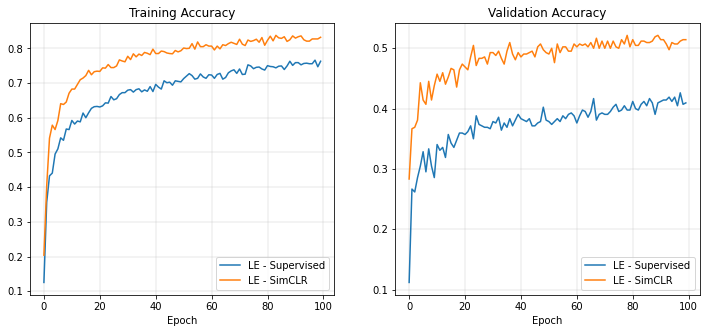

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=False)

ax[0].plot(le_sv['metrics_dict'][0]['train_acc'], label='LE - Supervised')
ax[0].plot(le_ssl['metrics_dict'][0]['train_acc'], label='LE - SimCLR')

ax[0].legend()
ax[0].grid(linewidth=0.3)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(le_sv['metrics_dict'][0]['valid_acc'], label='LE - Supervised')
ax[1].plot(le_ssl['metrics_dict'][0]['valid_acc'], label='LE - SimCLR')

ax[1].legend()
ax[1].grid(linewidth=0.3)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epoch')

Text(0.5, 0, 'Epoch')

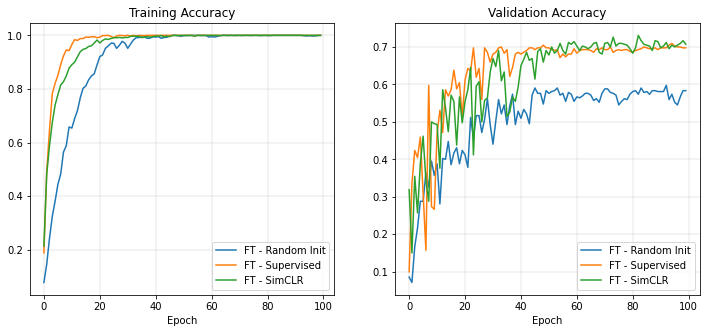

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=False)

ax[0].plot(ft_rand['metrics_dict'][0]['train_acc'][:100], label='FT - Random Init')
ax[0].plot(ft_sv['metrics_dict'][0]['train_acc'], label='FT - Supervised')
ax[0].plot(ft_ssl['metrics_dict'][0]['train_acc'], label='FT - SimCLR')

ax[0].legend()
ax[0].grid(linewidth=0.3)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(ft_rand['metrics_dict'][0]['valid_acc'][:100], label='FT - Random Init')
ax[1].plot(ft_sv['metrics_dict'][0]['valid_acc'], label='FT - Supervised')
ax[1].plot(ft_ssl['metrics_dict'][0]['valid_acc'], label='FT - SimCLR')

ax[1].legend()
ax[1].grid(linewidth=0.3)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epoch')